In [32]:
# install packages if you don't have
# !pip install scipy
# !pip install tensorflow
# !pip install scikeras

In [3]:
# import library/packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.tree import plot_tree
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from keras.layers import Dense
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor

"The task is to find the set of demographic characteristics that can best predict the median household income (per year) for census tracts"

In [4]:
# read dataset
df = pd.read_csv('CensusCanada2021Training.csv') # change the csv path for your version
df.columns = df.columns.str.replace(' ','_')
df

,Total_Population,Total_Households,Median_Household_Income_(Current_Year_$),Total_Households_For_Period_Of_Construction,Total_Households_For_Period_Of_Construction_Built_Before_1961,Total_Households_For_Period_Of_Construction_Built_Between_1961_And_1980,Total_Households_For_Period_Of_Construction_Built_Between_1981_And_190,Total_Households_For_Period_Of_Construction_Built_Between_1991_And_2000,Total_Households_For_Period_Of_Construction_Built_Between_2001_And_2005,Total_Households_For_Period_Of_Construction_Built_Between_2006_And_2010,Total_Households_For_Period_Of_Construction_Built_Between_2011_And_2015,Total_Households_For_Period_Of_Construction_Built_Between_2016_And_2021,Total_Households_For_Structure_Type_Houses,"Total_Households_For_Structure_Type_Apartment,_Building_Low_And_High_Rise",Total_Households_For_Structure_Type_Other_Dwelling_Types,Total_Households_for_Tenure,Dwellings_by_Tenure_Owner,Dwellings_by_Tenure_Renter
0,3088,1235.0,107000.0,1235.0,25.0,1130.0,50.0,15.0,10.0,10.0,0.0,0.0,1135,130,0,1235.0,1055.0,180.0
1,5889,1665.0,111000.0,1665.0,0.0,0.0,0.0,15.0,20.0,375.0,315.0,935.0,1605,50,10,1665.0,1365.0,300.0
2,8090,2775.0,105000.0,2775.0,105.0,150.0,240.0,1210.0,555.0,165.0,240.0,120.0,2375,400,0,2775.0,2360.0,420.0
3,4074,1775.0,65000.0,1775.0,210.0,1100.0,260.0,85.0,35.0,45.0,30.0,15.0,1265,275,235,1775.0,1375.0,400.0
4,3642,1385.0,101000.0,1385.0,10.0,190.0,1010.0,165.0,0.0,0.0,10.0,0.0,1035,325,25,1385.0,1250.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5366,3409,1460.0,84000.0,1460.0,15.0,0.0,0.0,0.0,20.0,40.0,465.0,915.0,780,675,5,1460.0,1060.0,400.0
5367,8408,4195.0,62800.0,4195.0,335.0,750.0,515.0,580.0,355.0,505.0,255.0,900.0,1505,2685,5,4195.0,1845.0,2350.0
5368,3609,1460.0,66000.0,1460.0,450.0,670.0,85.0,35.0,30.0,30.0,120.0,45.0,1220,275,0,1460.0,940.0,525.0
5369,3084,1165.0,100000.0,1165.0,70.0,365.0,280.0,180.0,105.0,80.0,50.0,40.0,815,335,15,1165.0,975.0,190.0


In [5]:
# list of variables containing null value
na_lst = df.columns[df.isna().any()].tolist()
print(len(na_lst))
print('Training Dataset: here is the list of variables containing null-value: ', na_lst)
# Remove Missing values
df1 = df.dropna()
df1.info()

14
Training Dataset: here is the list of variables containing null-value:  ['Total_Households', 'Median_Household_Income_(Current_Year_$)', 'Total_Households_For_Period_Of_Construction', 'Total_Households_For_Period_Of_Construction_Built_Before_1961', 'Total_Households_For_Period_Of_Construction_Built_Between_1961_And_1980', 'Total_Households_For_Period_Of_Construction_Built_Between_1981_And_190', 'Total_Households_For_Period_Of_Construction_Built_Between_1991_And_2000', 'Total_Households_For_Period_Of_Construction_Built_Between_2001_And_2005', 'Total_Households_For_Period_Of_Construction_Built_Between_2006_And_2010', 'Total_Households_For_Period_Of_Construction_Built_Between_2011_And_2015', 'Total_Households_For_Period_Of_Construction_Built_Between_2016_And_2021', 'Total_Households_for_Tenure', 'Dwellings_by_Tenure_Owner', 'Dwellings_by_Tenure_Renter']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 5370
Data columns (total 18 columns):
 #   Column                

# Part I

### EDA

In [6]:
# check duplicate columns
dup_col=[]
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            continue
        if df[col1].equals(df[col2]):
            dup_col.append(col1)
            dup_col.append(col2)
dup = list(set(dup_col))
print("These columns have the same values: ", dup)

These columns have the same values:  ['Total_Households_for_Tenure', 'Total_Households', 'Total_Households_For_Period_Of_Construction']


In [7]:
# drop two of the duplicate rows)
dup1 = ['Total_Households_For_Period_Of_Construction', 'Total_Households_for_Tenure']
df1 = df1.drop(columns = dup1)

In [8]:
# rename the variables
df1.rename(columns={'Total_Households_For_Period_Of_Construction_Built_Before_1961': 'Tot_Age>63', 'Total_Households_For_Period_Of_Construction_Built_Between_1961_And_1980': 'Tot_Age>43',
                    'Total_Households_For_Period_Of_Construction_Built_Between_1981_And_190': 'Tot_Age>33', 'Total_Households_For_Period_Of_Construction_Built_Between_1991_And_2000': 'Tot_Age>23',
                    'Total_Households_For_Period_Of_Construction_Built_Between_2001_And_2005': 'Tot_Age>18', 'Total_Households_For_Period_Of_Construction_Built_Between_2006_And_2010': 'Tot_Age>13',
                    'Total_Households_For_Period_Of_Construction_Built_Between_2011_And_2015': 'Tot_Age>8', 'Total_Households_For_Period_Of_Construction_Built_Between_2016_And_2021': 'Tot_Age>2'},inplace=True)

In [9]:
df1.info()
df2 = df1.copy()
df4 = df1.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 5370
Data columns (total 16 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Total_Population                                                           5245 non-null   int64  
 1   Total_Households                                                           5245 non-null   float64
 2   Median_Household_Income_(Current_Year_$)                                   5245 non-null   float64
 3   Tot_Age>63                                                                 5245 non-null   float64
 4   Tot_Age>43                                                                 5245 non-null   float64
 5   Tot_Age>33                                                                 5245 non-null   float64
 6   Tot_Age>23                                              

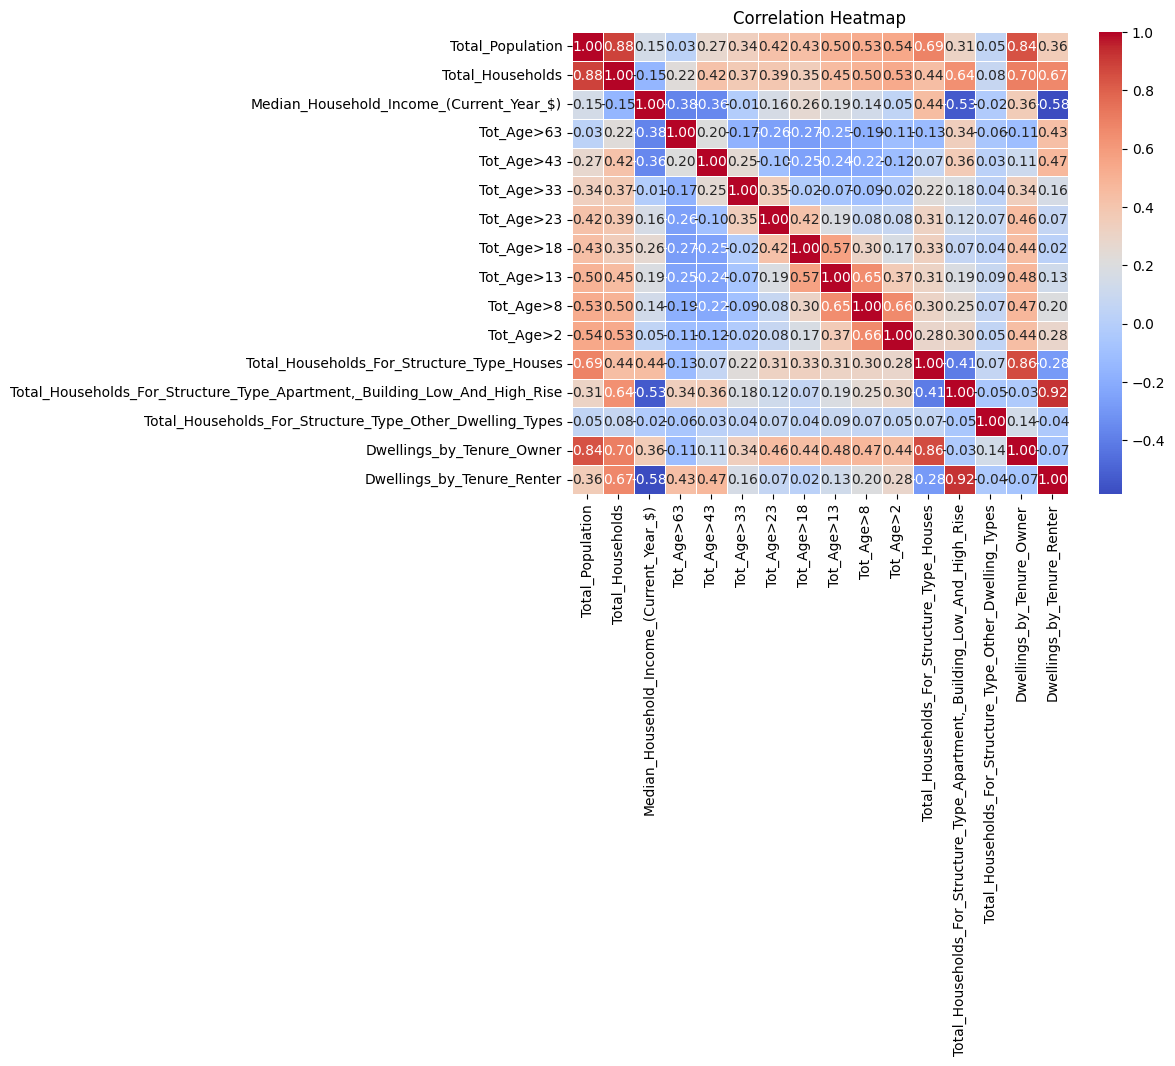

In [11]:
# corr matrix
cm=df1.corr()
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

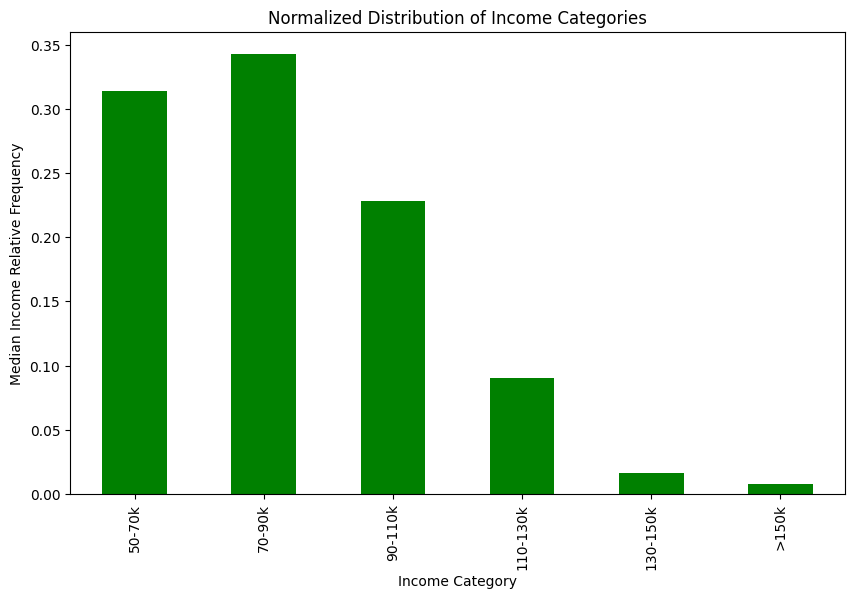

In [12]:
# find the frequency of median_income in different categories
bins = [50000, 70000, 90000, 110000, 130000, 150000, float('inf')]
labels = ['50-70k', '70-90k', '90-110k', '110-130k', '130-150k', '>150k']
df1['Income_Category'] = pd.cut(df1['Median_Household_Income_(Current_Year_$)'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
relative_freq = df1['Income_Category'].value_counts(normalize=True).sort_index()
relative_freq.plot(kind='bar', color='green')

plt.xlabel('Income Category')
plt.ylabel('Median Income Relative Frequency')
plt.title('Normalized Distribution of Income Categories')
plt.show()

<Figure size 1200x600 with 0 Axes>

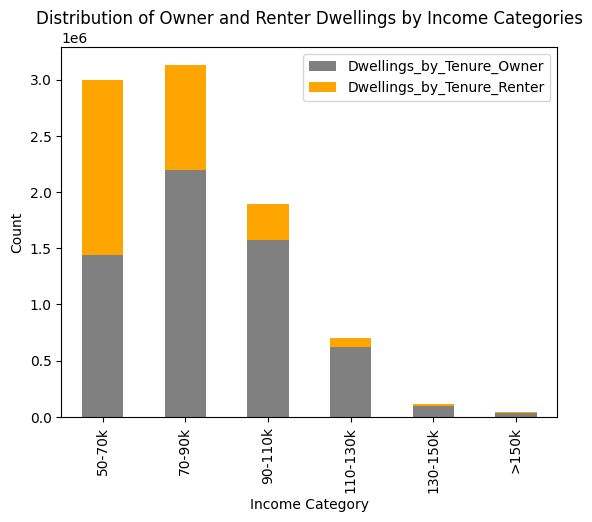

In [13]:
# number of houses owned and rented by each income range to find out the disposal income of each income group
bins = [50000, 70000, 90000, 110000, 130000, 150000, float('inf')]
labels = ['50-70k', '70-90k', '90-110k', '110-130k', '130-150k', '>150k']
df1['Income_Category'] = pd.cut(df1['Median_Household_Income_(Current_Year_$)'], bins=bins, labels=labels)

pivot_table = pd.pivot_table(df1, values=['Dwellings_by_Tenure_Owner', 'Dwellings_by_Tenure_Renter'],
                              index='Income_Category', aggfunc='sum')

plt.figure(figsize=(12, 6))
colors = ['grey', 'orange']
pivot_table.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Distribution of Owner and Renter Dwellings by Income Categories')
plt.show()

*   finding:  As income increases, the ratio of house rental significanly decreases

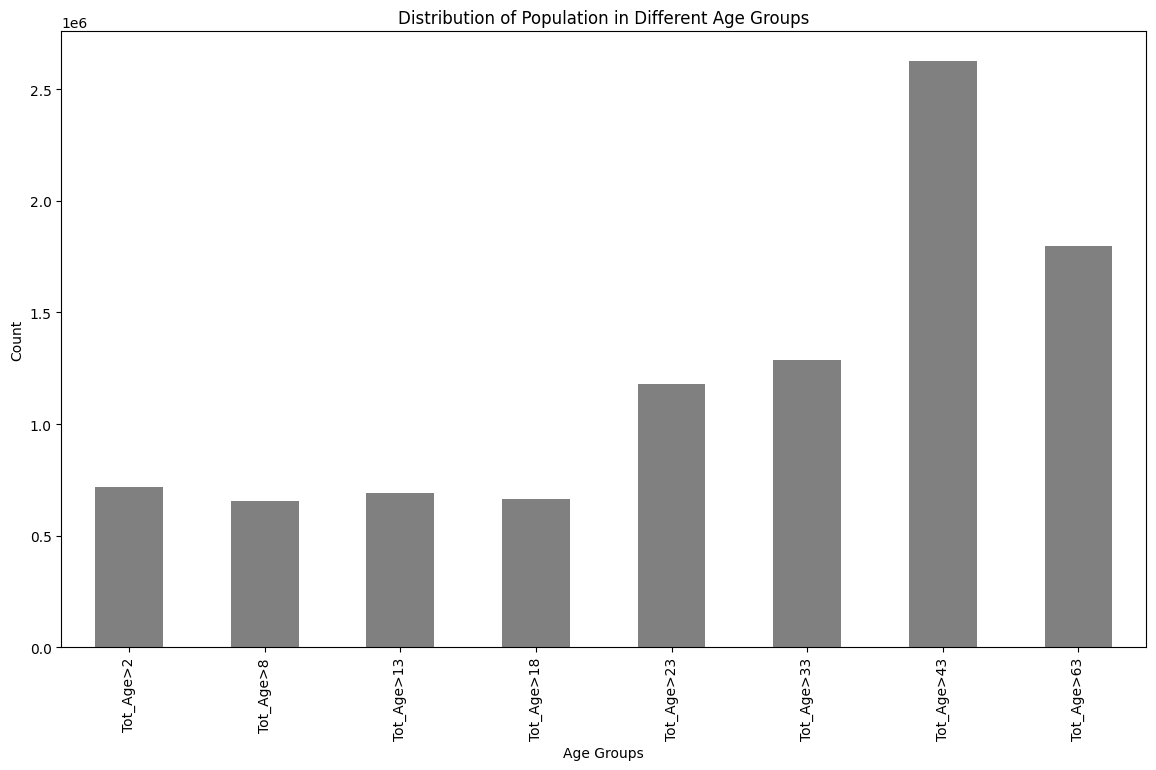

In [14]:
# group those house by age (since it was built)
plt.figure(figsize=(14, 8))
df1[['Tot_Age>2', 'Tot_Age>8', 'Tot_Age>13', 'Tot_Age>18', 'Tot_Age>23', 'Tot_Age>33', 'Tot_Age>43', 'Tot_Age>63']].sum().plot(kind='bar', color='grey')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.title('Distribution of Population in Different Age Groups')
plt.show()

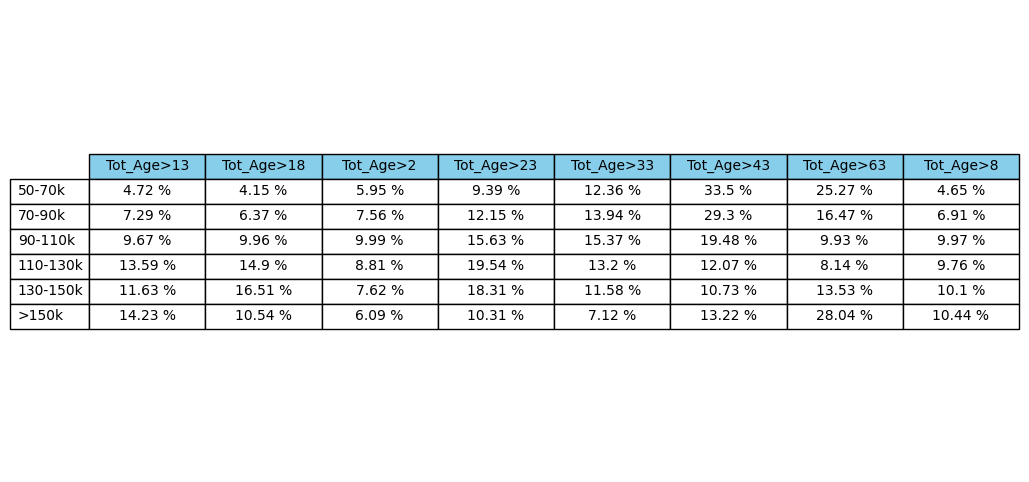

In [15]:
bins = [50000, 70000, 90000, 110000, 130000, 150000, float('inf')]
labels = ['50-70k', '70-90k', '90-110k', '110-130k', '130-150k', '>150k']
df1['Income_Category'] = pd.cut(df1['Median_Household_Income_(Current_Year_$)'], bins=bins, labels=labels)
pivot_table = pd.pivot_table(df1, values=['Tot_Age>2', 'Tot_Age>8', 'Tot_Age>13', 'Tot_Age>18', 'Tot_Age>23', 'Tot_Age>33', 'Tot_Age>43', 'Tot_Age>63'],
                              index='Income_Category', aggfunc='sum')

pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
table_data = pivot_table_percentage.round(2).astype(str) + ' %'
table = ax.table(cellText=table_data.values, colLabels=pivot_table_percentage.columns, rowLabels=pivot_table_percentage.index, loc='center', cellLoc='center', colColours=['skyblue']*8)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)
plt.show()

<Figure size 1400x800 with 0 Axes>

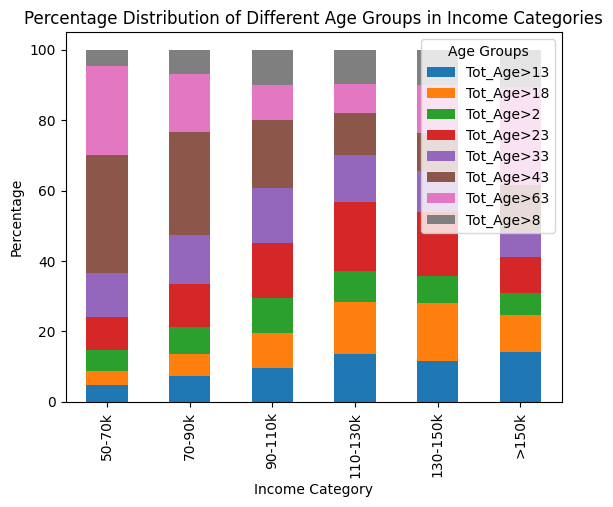

In [16]:
bins = [50000, 70000, 90000, 110000, 130000, 150000, float('inf')]
labels = ['50-70k', '70-90k', '90-110k', '110-130k', '130-150k', '>150k']
df1['Income_Category'] = pd.cut(df1['Median_Household_Income_(Current_Year_$)'], bins=bins, labels=labels)

pivot_table = pd.pivot_table(df1, values=['Tot_Age>2', 'Tot_Age>8', 'Tot_Age>13', 'Tot_Age>18', 'Tot_Age>23', 'Tot_Age>33', 'Tot_Age>43', 'Tot_Age>63'],
                              index='Income_Category', aggfunc='sum')

pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
pivot_table_percentage.plot(kind='bar', stacked=True)
plt.xlabel('Income Category')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Different Age Groups in Income Categories')
plt.legend(title='Age Groups', loc='upper right')
plt.show()

*   Findings:  the old houses (age > 63 years) are predominantly occupied by both the lowest and highest income groups.

### KMeans Clustering


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

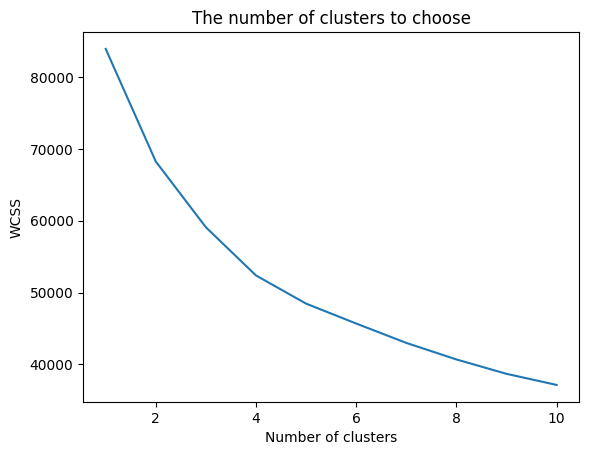

In [29]:
# split dataset
Scaler = StandardScaler()
df4_scaled = Scaler.fit_transform(df4)

# elbow method
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(df4_scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title("The number of clusters to choose")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

The optimal k-mean value is 4.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


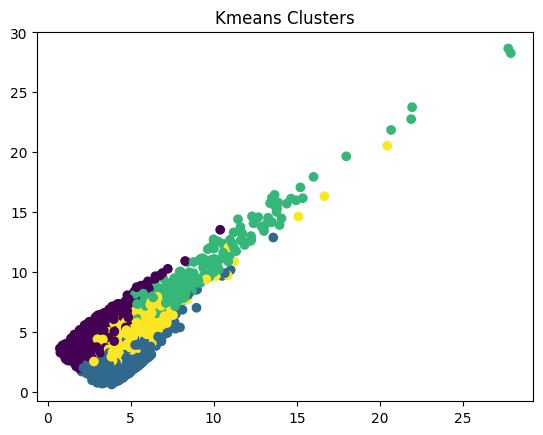

In [30]:
km = KMeans(n_clusters=4, init = 'k-means++', random_state = 42)
distances = km.fit_transform(df4_scaled)
labels = km.labels_
plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')
plt.show()

In [31]:
df3 = df4.copy()
df3['labels'] = labels
# one-hot encoding
dummies = pd.get_dummies(df3['labels'], prefix='labels')
# update dataset
df3.drop(columns = ['labels'], inplace = True)
df3 = pd.concat([df3, dummies], axis=1)

clt_0 = df3[df3["labels_0"] == 1]
clt_1 = df3[df3["labels_1"] == 1]
clt_2 = df3[df3["labels_2"] == 1]
clt_3 = df3[df3["labels_3"] == 1]

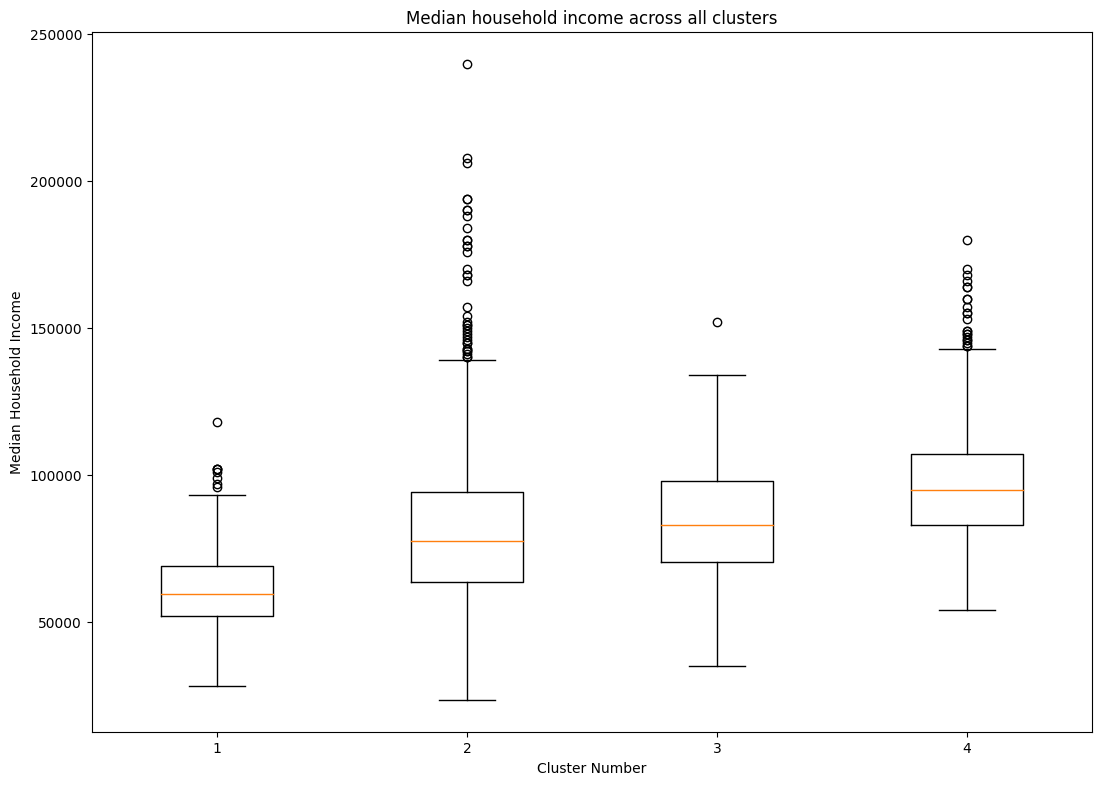

In [32]:
data_1 = clt_0["Median_Household_Income_(Current_Year_$)"]
data_2 = clt_1["Median_Household_Income_(Current_Year_$)"]
data_3 = clt_2["Median_Household_Income_(Current_Year_$)"]
data_4 = clt_3["Median_Household_Income_(Current_Year_$)"]
data = [data_1, data_2, data_3, data_4]

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
plt.title("Median household income across all clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Median Household Income")
plt.show()

<Axes: >

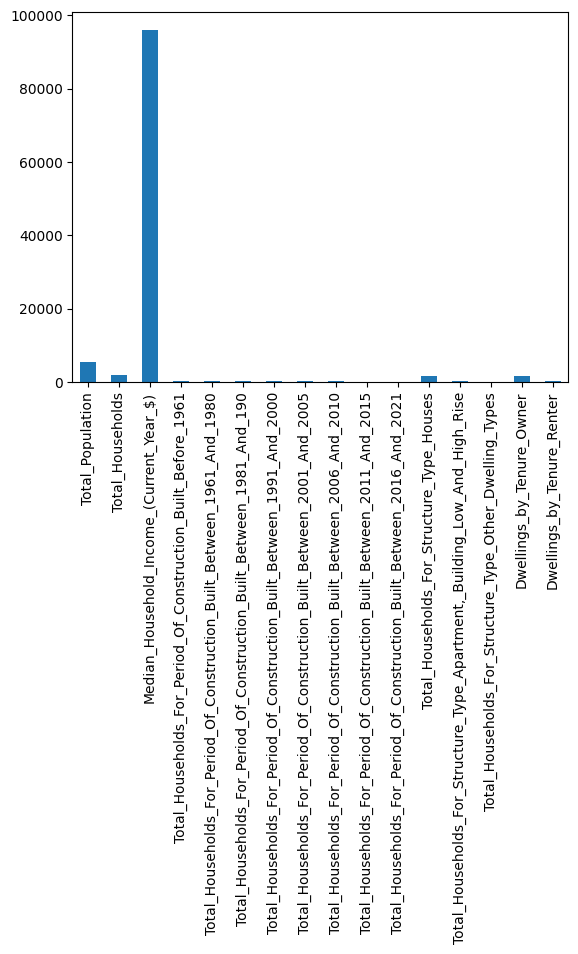

In [33]:
columns_to_exclude = ['labels_0', 'labels_1', 'labels_2', 'labels_3']  # List of columns to exclude
columns_except_specific_0 = clt_0.loc[:, ~clt_0.columns.isin(columns_to_exclude)].mean()
columns_except_specific_1 = clt_1.loc[:, ~clt_1.columns.isin(columns_to_exclude)].mean()
columns_except_specific_2 = clt_2.loc[:, ~clt_2.columns.isin(columns_to_exclude)].mean()
columns_except_specific_3 = clt_3.loc[:, ~clt_3.columns.isin(columns_to_exclude)].mean()

data_stats = [columns_except_specific_0, columns_except_specific_1, columns_except_specific_2, columns_except_specific_3]

# Plotting a bar graph for each attribute across the clusters
columns_except_specific_3.plot(kind = "bar")

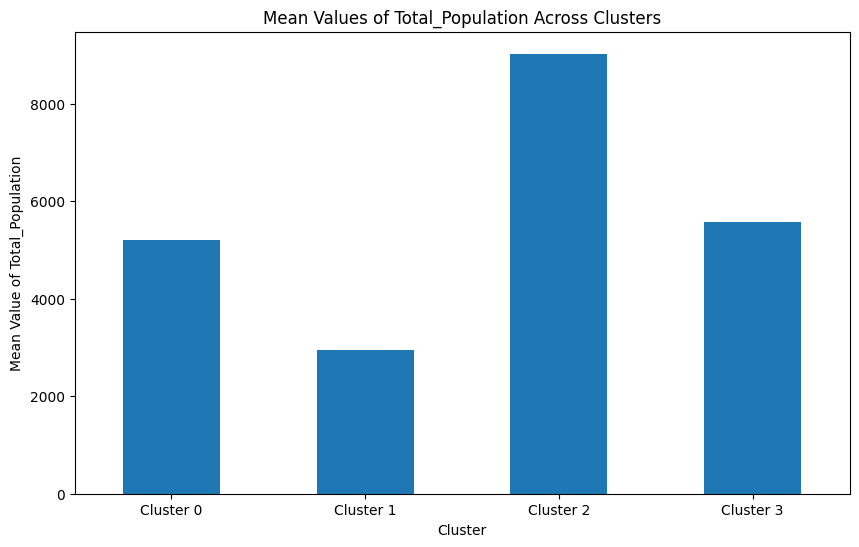

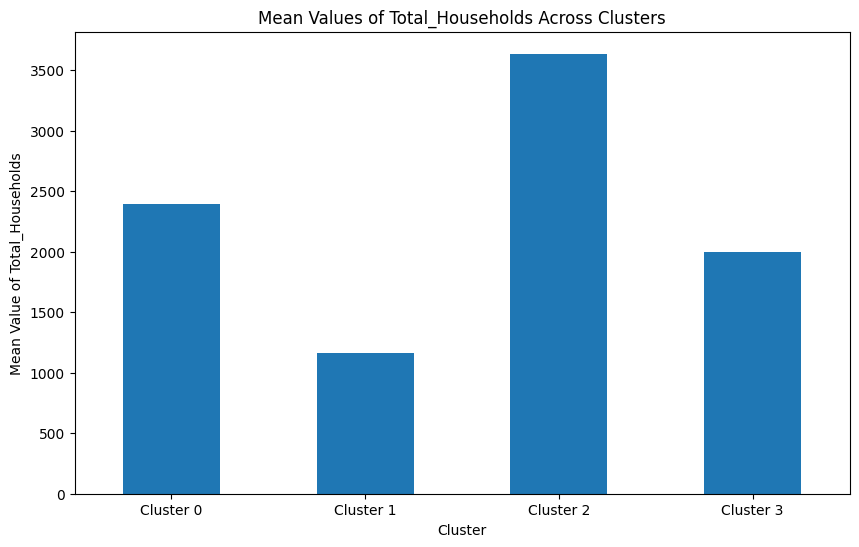

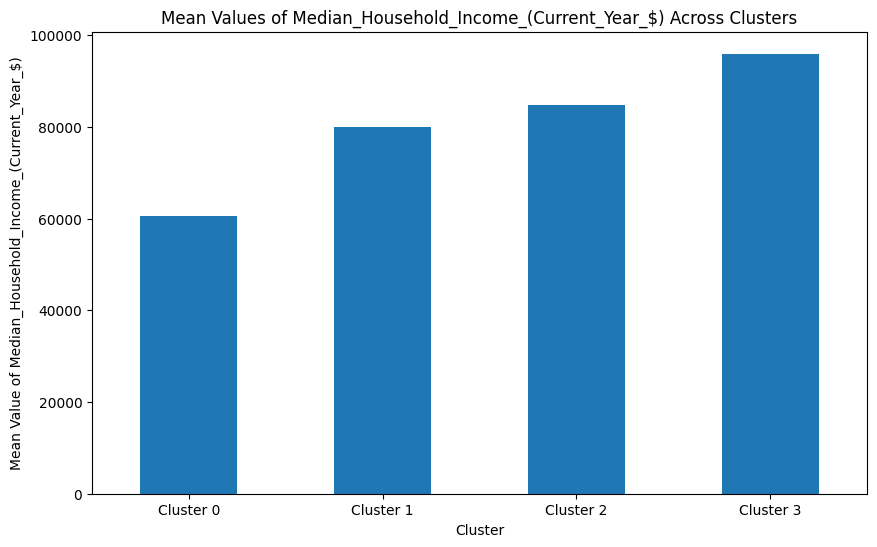

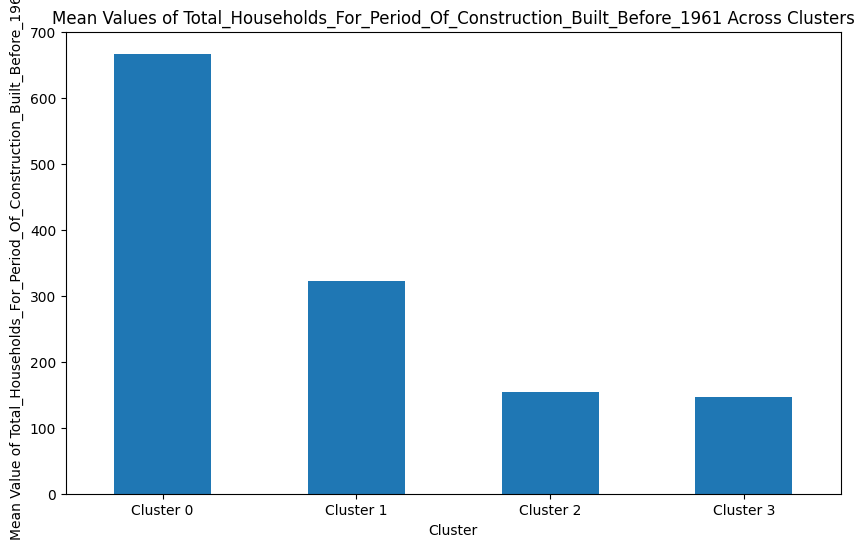

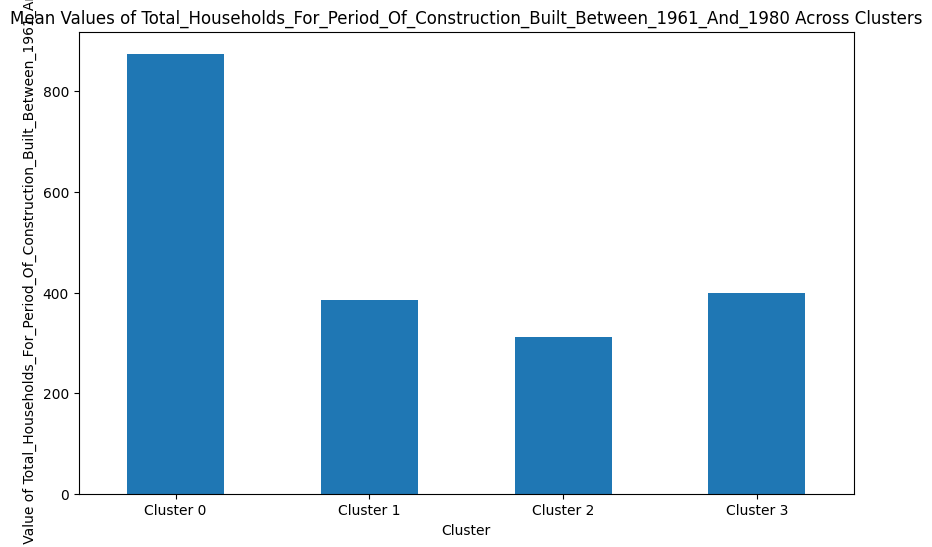

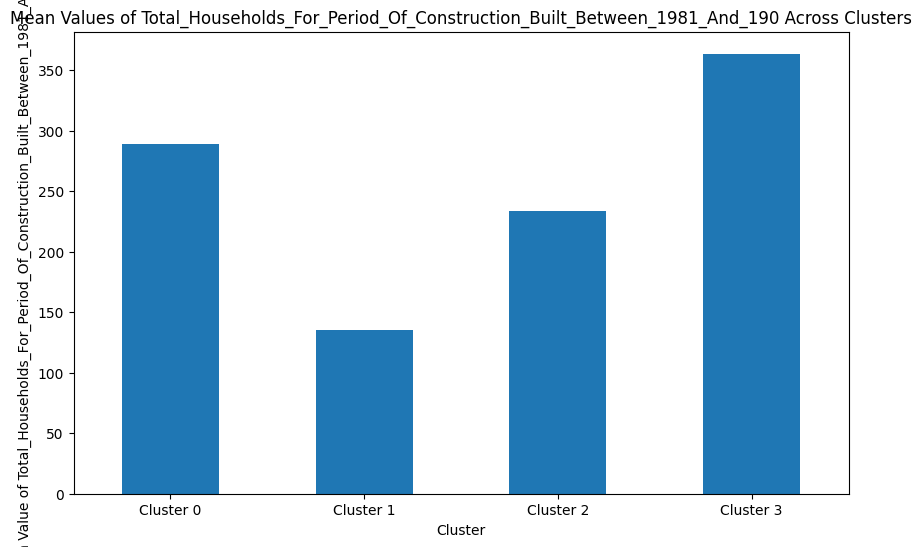

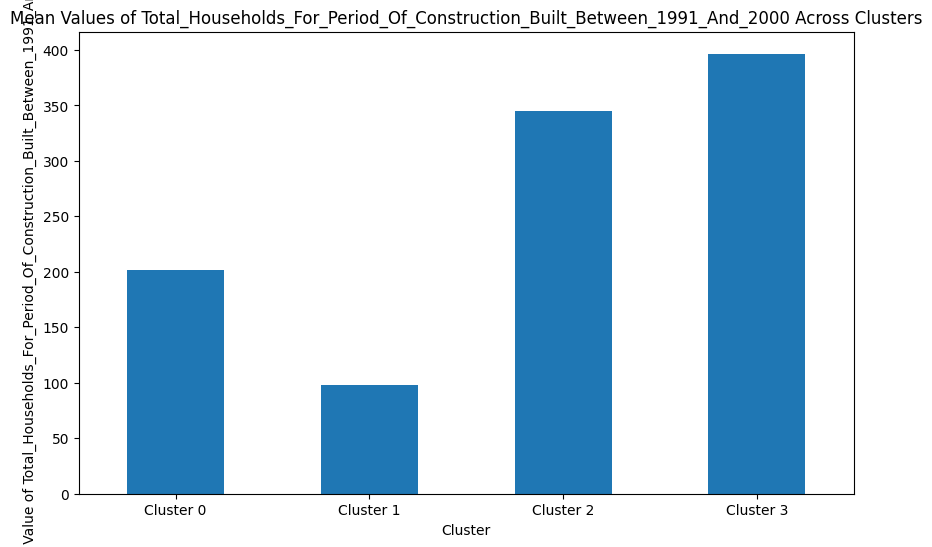

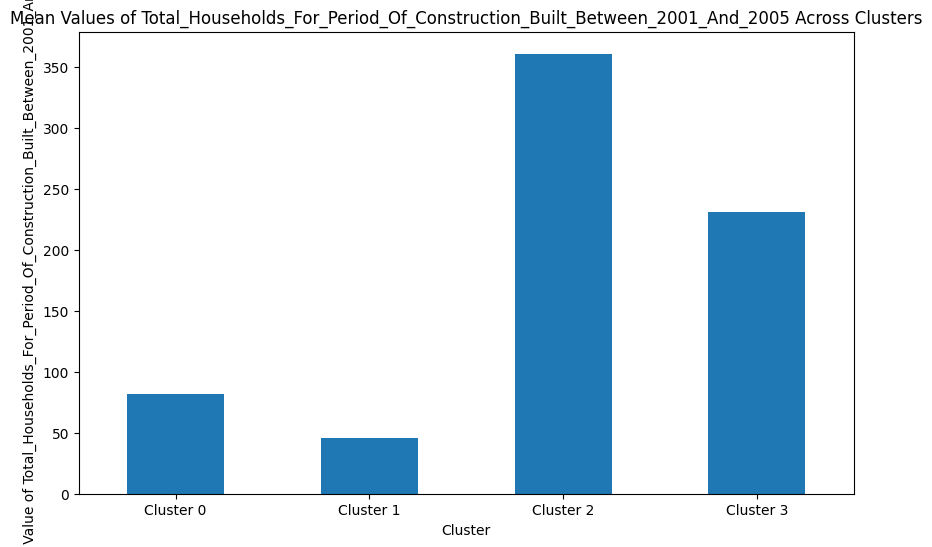

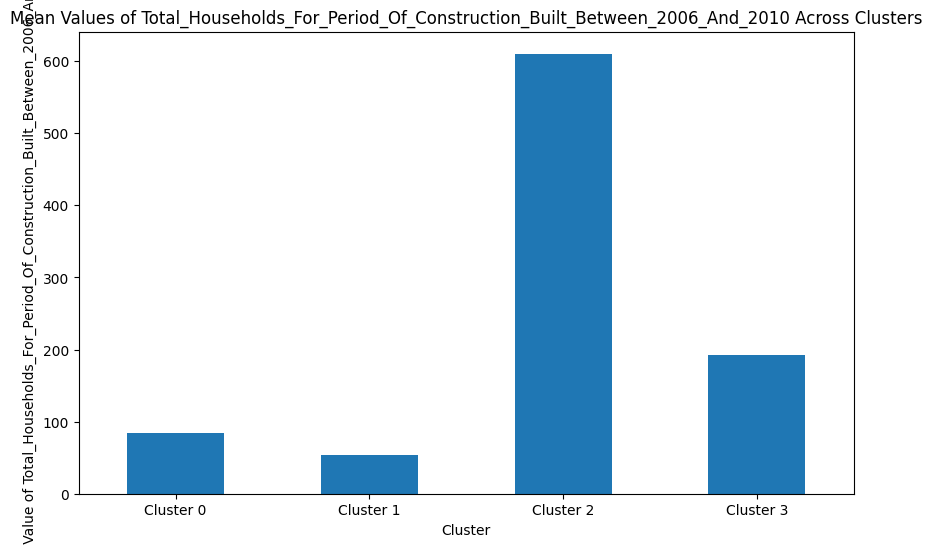

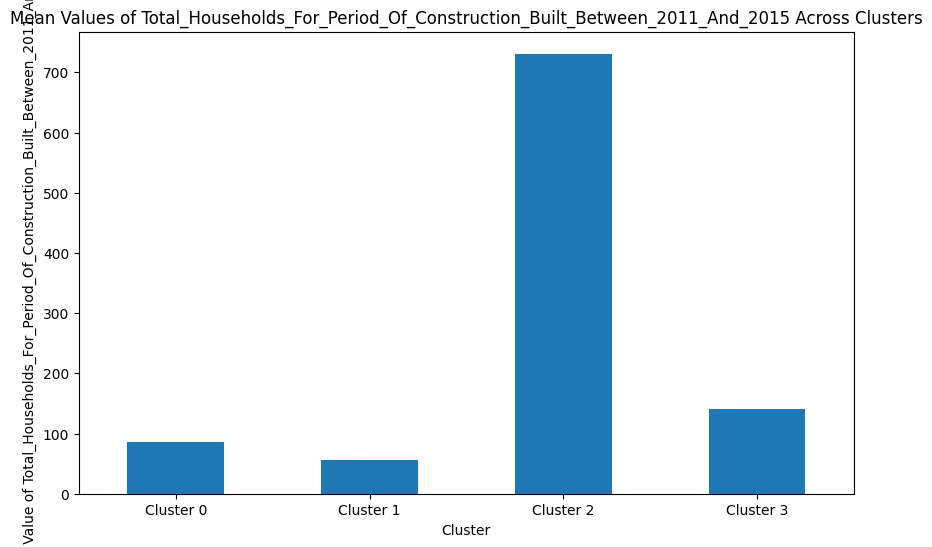

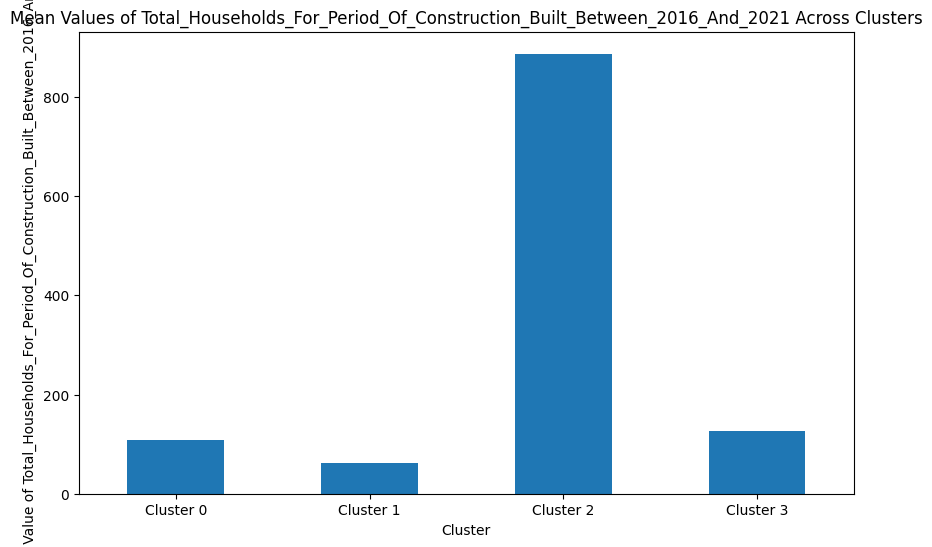

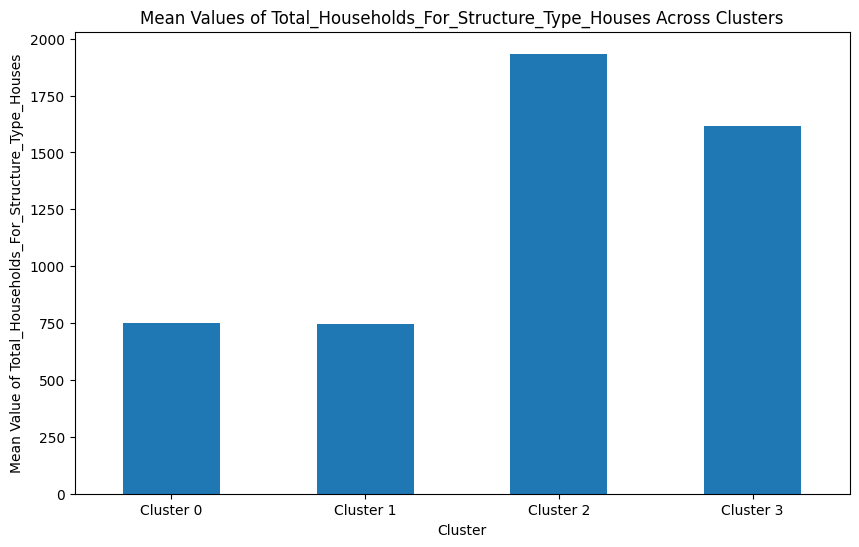

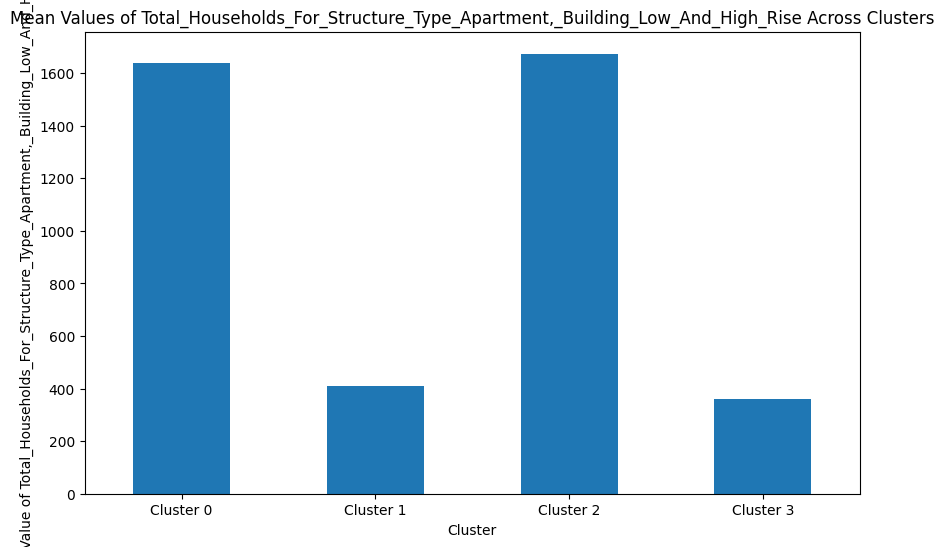

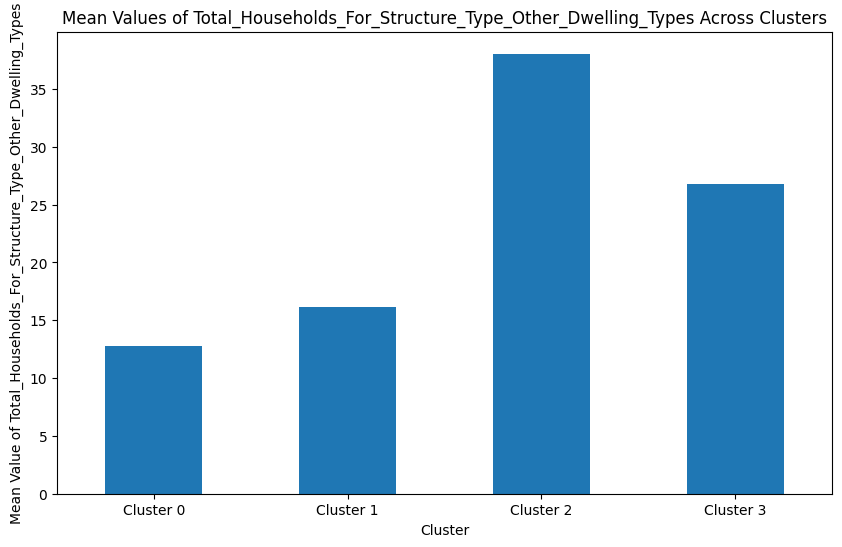

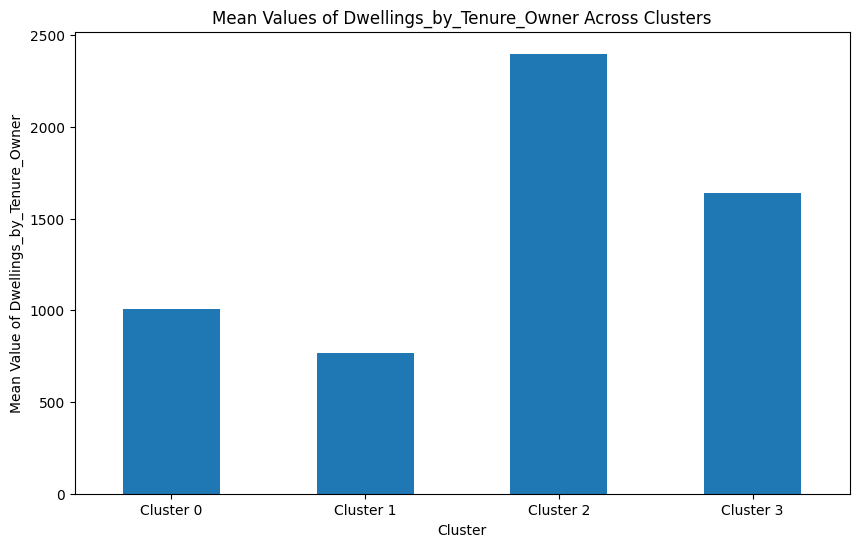

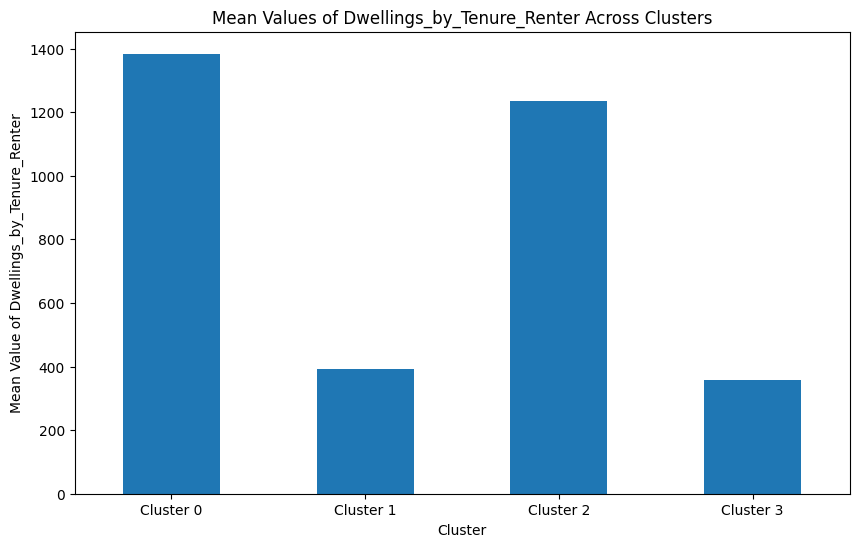

In [34]:
combined_means = pd.DataFrame({
    'Cluster 0': columns_except_specific_0,
    'Cluster 1': columns_except_specific_1,
    'Cluster 2': columns_except_specific_2,
    'Cluster 3': columns_except_specific_3
})

# Transpose the DataFrame so that each row is an attribute and each column is a cluster
combined_means_transposed = combined_means.T

# Plotting a bar plot for each attribute
for attribute in combined_means_transposed.columns:
    plt.figure(figsize=(10, 6))
    combined_means_transposed[attribute].plot(kind='bar')
    plt.title(f'Mean Values of {attribute} Across Clusters')
    plt.ylabel(f'Mean Value of {attribute}')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.show()

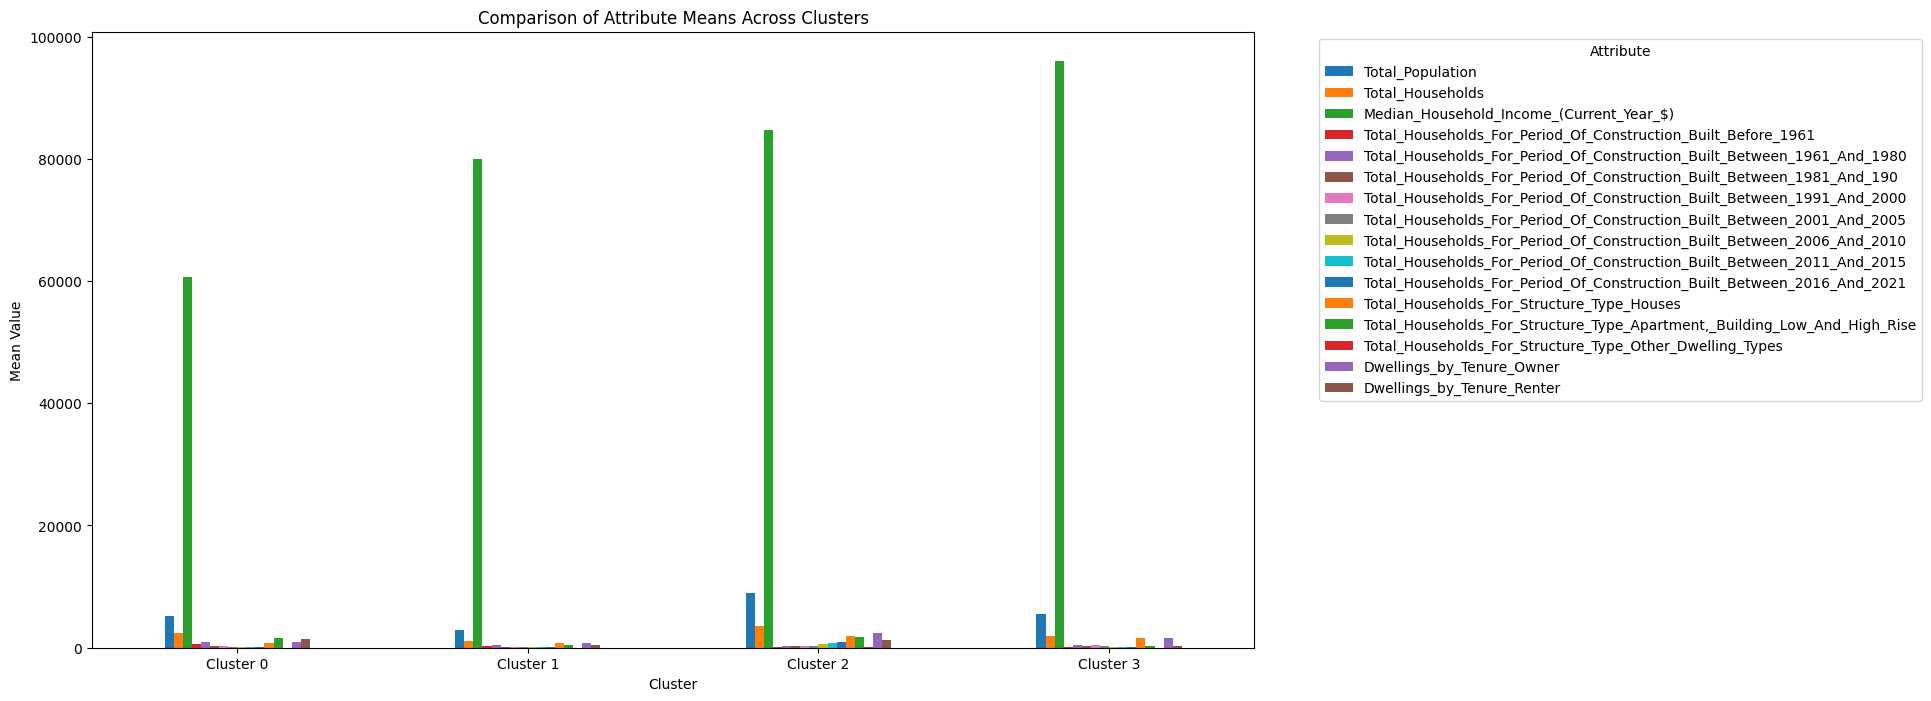

In [35]:
combined_means = pd.DataFrame({'Cluster 0': columns_except_specific_0,
                               'Cluster 1': columns_except_specific_1,
                               'Cluster 2': columns_except_specific_2,
                               'Cluster 3': columns_except_specific_3})

# Transpose for easier plotting
combined_means = combined_means.T

# Plotting
plt.figure(figsize=(15, 8))
combined_means.plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Attribute Means Across Clusters')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(title='Attribute', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Part II
(use df2 only)

## Clustering Model


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

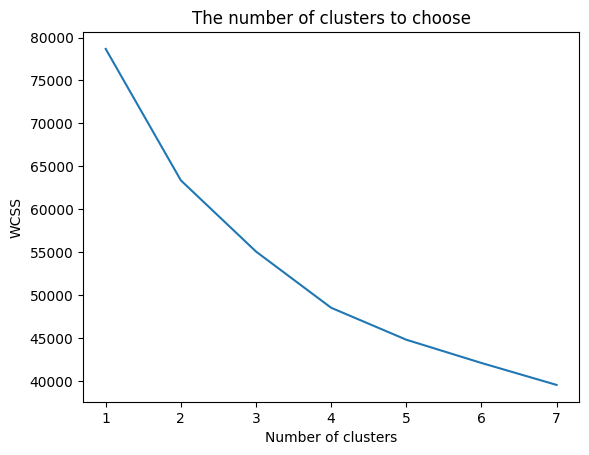

In [10]:
# split dataset
Y = df2['Median_Household_Income_(Current_Year_$)']
X = df2.drop(columns = ['Median_Household_Income_(Current_Year_$)'])
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

# elbow method
wcss = []
for i in range(1, 8):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 8), wcss)
plt.title("The number of clusters to choose")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

The optimal k-mean value is 4.

In [11]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
distances = kmeans.fit_transform(X_scaled)
labels = kmeans.labels_
#add cluster labe
df2['labels'] = labels
df4 = df2.copy()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# one-hot encoding
dummies = pd.get_dummies(df2['labels'], prefix='labels')
# update dataset
df2.drop(columns = ['labels'], inplace = True)
df2 = pd.concat([df2, dummies], axis=1)

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 5370
Data columns (total 20 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Total_Population                                                           5245 non-null   int64  
 1   Total_Households                                                           5245 non-null   float64
 2   Median_Household_Income_(Current_Year_$)                                   5245 non-null   float64
 3   Tot_Age>63                                                                 5245 non-null   float64
 4   Tot_Age>43                                                                 5245 non-null   float64
 5   Tot_Age>33                                                                 5245 non-null   float64
 6   Tot_Age>23                                              

## Feature Engineering - Decision Tree

### Split dataset into Train and Validation

In [75]:
# split dataset
y = df2['Median_Household_Income_(Current_Year_$)'].values
x = df2.drop(columns = ['Median_Household_Income_(Current_Year_$)'])

validation_ratio = 0.2
# Split out train&validation data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_ratio, random_state = 1, shuffle = True)

# Next, rescale the features
scaler = MinMaxScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

### build Tree

In [76]:
Tree=DecisionTreeRegressor()
Tree.fit(x_train_scaled, y_train_scaled)
print('Accuracy is :', Tree.score(x_train_scaled, y_train_scaled))
print('Accuracy for validation set is :', Tree.score(x_val_scaled, y_val_scaled))
Tree.get_params()

Accuracy is : 1.0
Accuracy for validation set is : 0.42992110597857924


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [77]:
# parameter grid
param_grid_tree = {
    'max_depth': range(3, 30, 2),
    'criterion':['poisson','friedman_mse', 'squared_error', 'absolute_error'],
    'min_samples_split':range(2, 15)
}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid_tree, cv=5, n_jobs=-1)
grid_search_tree.fit(x_val_scaled, y_val_scaled)
# best score found by GridSearchCV
print('Best score: ',grid_search_tree.best_score_)
print('Best params: ',grid_search_tree.best_params_)

Best score:  0.5335150589814589
Best params:  {'criterion': 'poisson', 'max_depth': 5, 'min_samples_split': 10}


In [78]:
bestClassTree = grid_search_tree.best_estimator_
bestClassTree.fit(x_train_scaled,y_train_scaled)

DecisionTreeRegressor(criterion='poisson', max_depth=5, min_samples_split=10,
                      random_state=1)

<Axes: >

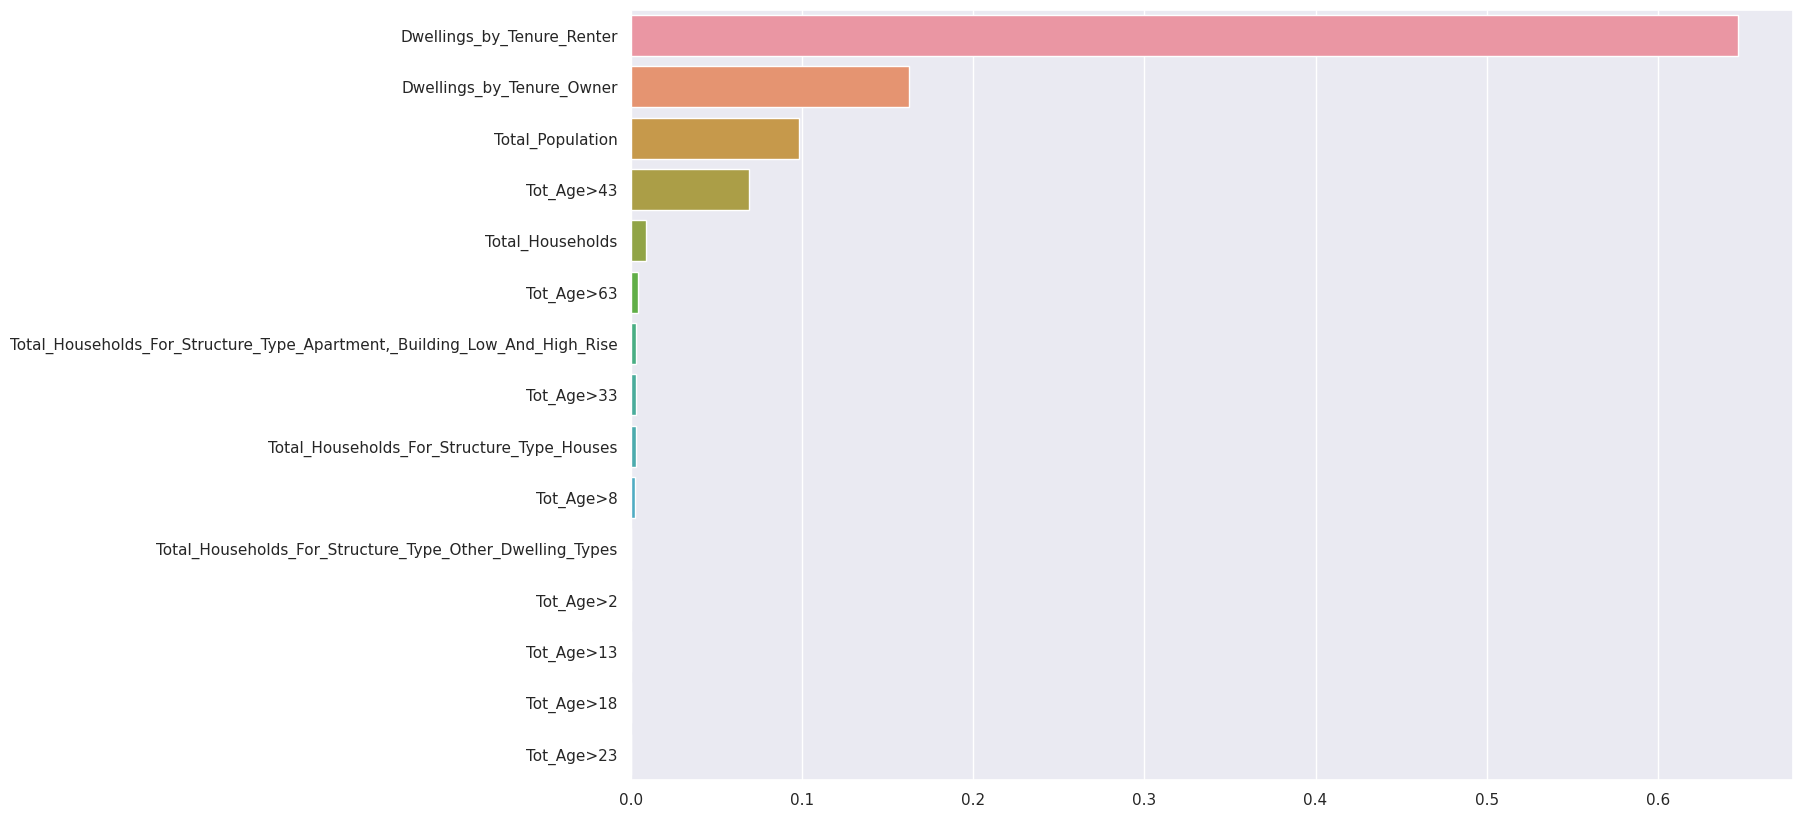

In [79]:
# Find important features
feature_importances = bestClassTree.feature_importances_
# Decide on a threshold for keeping features (for example, keep features with importance greater than the average)
mask = feature_importances > 0
# Use the mask to select the feature names
important_feature_names = x_train.columns[mask].tolist()
# Sort all features by their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = x_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

In [80]:
print(len(important_feature_names))
print('Selected features: ', important_feature_names)

10
Selected features:  ['Total_Population', 'Total_Households', 'Tot_Age>63', 'Tot_Age>43', 'Tot_Age>33', 'Tot_Age>8', 'Total_Households_For_Structure_Type_Houses', 'Total_Households_For_Structure_Type_Apartment,_Building_Low_And_High_Rise', 'Dwellings_by_Tenure_Owner', 'Dwellings_by_Tenure_Renter']


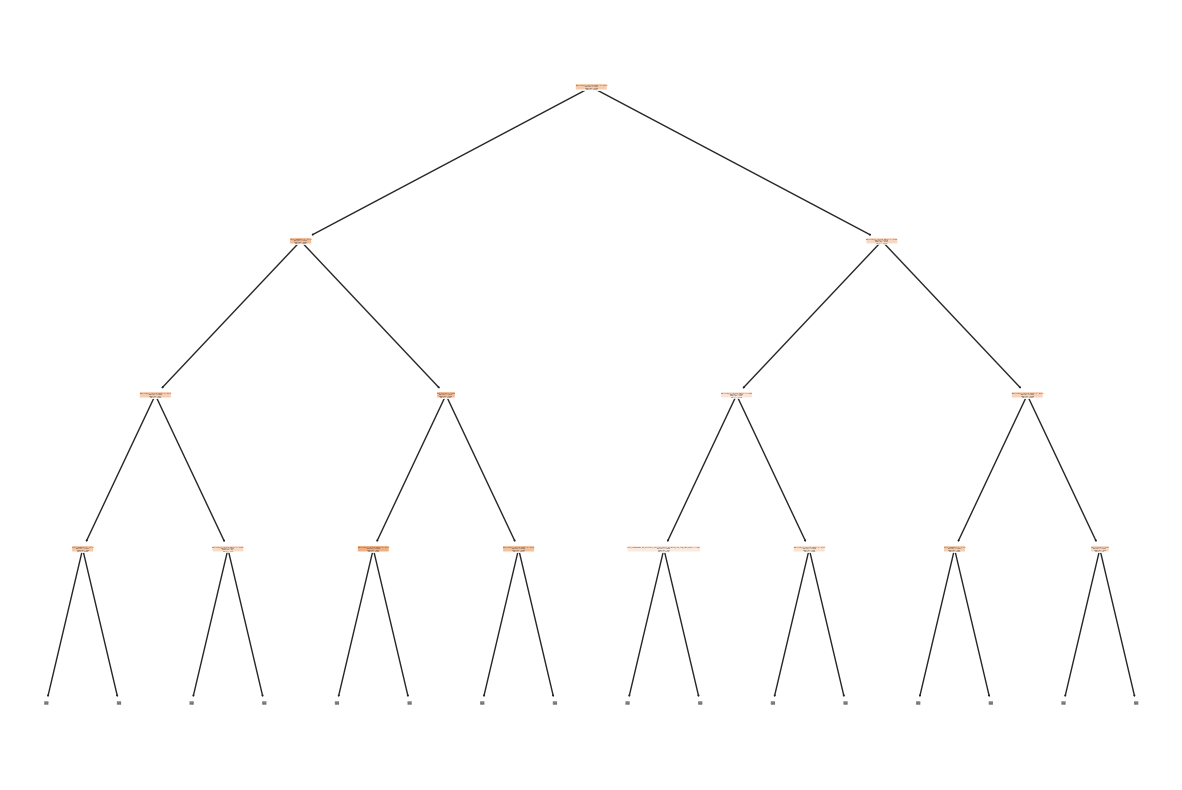

In [81]:
plot_tree(bestClassTree,
          filled=True,
          rounded=True,
          feature_names=x.columns,
          max_depth=3)  # Only show the top 3 levels
plt.show()

In [82]:
# Make predictions on the validation set
y_val_pred = bestClassTree.predict(x_val_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val_scaled, y_val_pred)
print("Mean Squared Error (MSE) on validation:", mse)

# Calculate R-squared score
r_squared = r2_score(y_val_scaled, y_val_pred)
print("R-squared on validation:", r_squared)

Mean Squared Error (MSE) on validation: 0.0052440824734134904
R-squared on validation: 0.5966209123147241


## Feature Engineering - lasso regression

In [83]:
## Build logistic regression (lasso) - need to delete
best_lasso = LassoCV(cv=5, random_state=1, max_iter=10000)
best_lasso.fit(x_train_scaled, y_train_scaled)
print(f'Optimal alpha for the Lasso is {best_lasso.alpha_}')
acc_score_lasso_train_best = best_lasso.score(x_train_scaled, y_train_scaled)
acc_score_lasso_val_best = best_lasso.score(x_val_scaled, y_val_scaled)
print("Accuracy after hyperparameter tuning for training: ", acc_score_lasso_train_best)
print("Accuracy after hyperparameter tuning for validation: ", acc_score_lasso_val_best)
print('\n')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal alpha for the Lasso is 7.3388136496766334e-06
Accuracy after hyperparameter tuning for training:  0.5398143432330209
Accuracy after hyperparameter tuning for validation:  0.48100558203083055




decision tree has better performance.

## Model Building

### Helper Function

In [14]:
# predict + evaluate
def predict (regressor, train_x, train_y, test_x, test_y):
  fit = regressor.fit(train_x, train_y)
  y_pred_test = fit.predict(test_x)
  y_pred_train = fit.predict(train_x)
  # evaluate
  mse_train = mean_squared_error(train_y,y_pred_train)
  score_r2_train = r2_score(train_y,y_pred_train)
  mse_test = mean_squared_error(test_y,y_pred_test)
  score_r2_test = r2_score(test_y,y_pred_test)
  print('Model Performance')
  print('mse_train: ', mse_train)
  print('r2_train: ', score_r2_train)
  print('mse_test: ', mse_test)
  print('r2_test: ', score_r2_test)
  return None

def find_best_k2(X, y, max_k):
  # Function to find the optimal k with the highest cv score for KNN regressor
  range_k = range(1, max_k)
  best_k = 1
  best_mse = float('inf')
  mse_lst = []

  for k in range_k:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    kfold=KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(knn_regressor, X, y, cv=kfold, scoring='neg_mean_squared_error')
    mse = -scores.mean()  # Negative MSE to positive value
    mse_lst.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_k = k

  # plot the result
  plt.plot(range_k, mse_lst)
  plt.xlabel('Number of Neighbors')
  plt.ylabel('CV MSE')
  plt.title('KNN Regressor - Cross Validation')
  plt.show()

  return best_k, best_mse

### Split dataset into Train and Validation

In [15]:
# Use Desicion Tree for feature engineering
important_feature_names = ['Total_Population', 'Total_Households', 'Tot_Age>63', 'Tot_Age>43', 'Tot_Age>33', 'Tot_Age>8', 'Total_Households_For_Structure_Type_Houses', 'Total_Households_For_Structure_Type_Apartment,_Building_Low_And_High_Rise', 'Dwellings_by_Tenure_Owner', 'Dwellings_by_Tenure_Renter']
x = df2[important_feature_names]
y = df2['Median_Household_Income_(Current_Year_$)'].values

validation_ratio = 0.2
# Split out train data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_ratio, random_state = 1, shuffle = True)

# Next, rescale the features
Scaler = MinMaxScaler().fit(x_train)
x_train_scaled = Scaler.transform(x_train)
x_val_scaled = Scaler.transform(x_val)

Scaler_y = MinMaxScaler()
y_train_scaled = Scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = Scaler_y.transform(y_val.reshape(-1, 1))

### KNN


In [102]:
KNN = KNeighborsRegressor()
KNN.fit(x_train_scaled, y_train_scaled)
# print parameters of model
print('model parameters:', KNN.get_params())
# evaluation
predict(KNN, x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)

model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Model Performance
mse_train:  0.0027656878868372644
r2_train:  0.7593162914230611
mse_test:  0.004909246835001566
r2_test:  0.6223767418677253


#### hyperparameter tuning


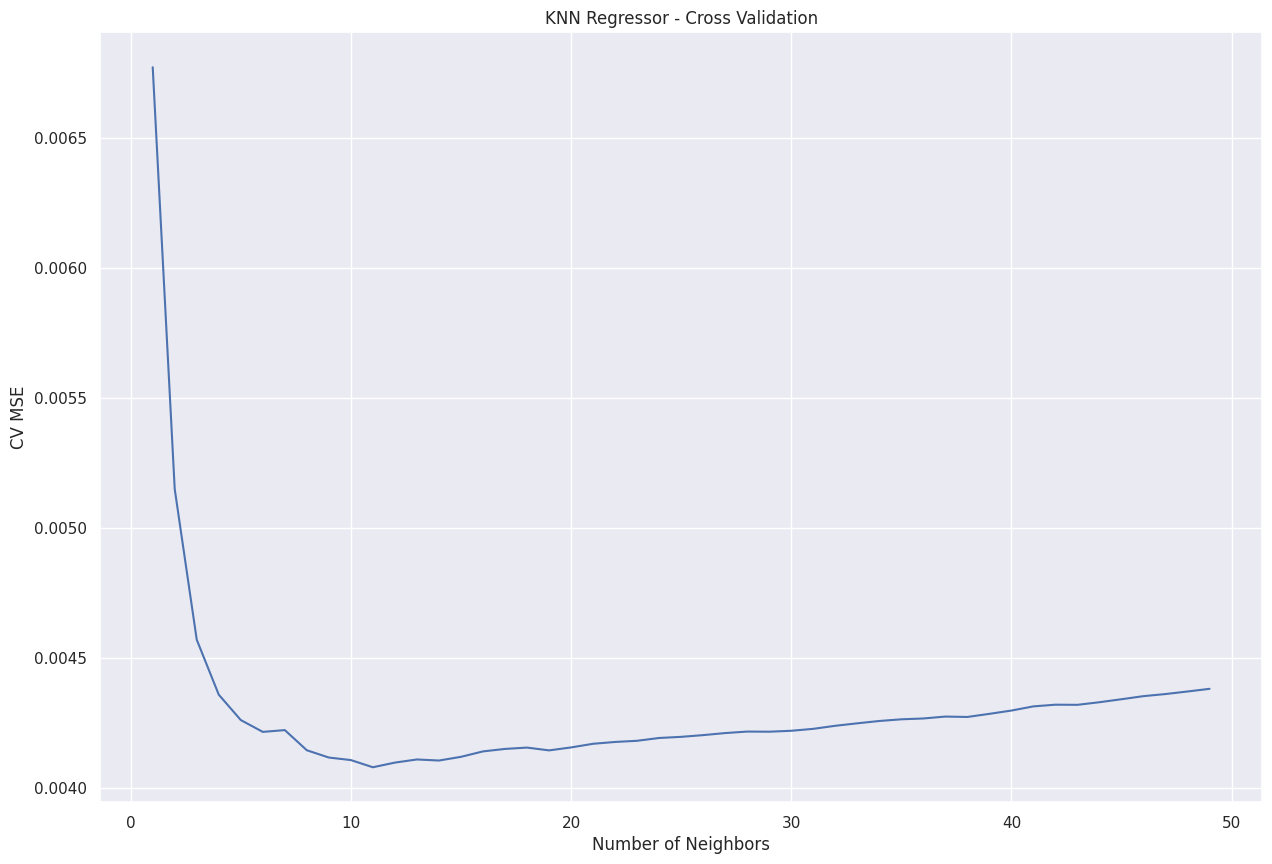

Best k: 11
Accuracy with best k: 0.00408


In [88]:
best_k, best_accuracy = find_best_k2(x_train_scaled, y_train_scaled, 50)
print(f"Best k: {best_k}")
print(f"Accuracy with best k: {best_accuracy:.5f}")

In [104]:
# Build and train model with the optimal k we found previously
knn_regres = KNeighborsRegressor(n_neighbors=best_k)
knn_regres.fit(x_train_scaled, y_train_scaled)
predict(knn_regres, x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)

Model Performance
mse_train:  0.003335177424922339
r2_train:  0.7097565219803754
mse_test:  0.004945861464721996
r2_test:  0.619560314779204


### ANN


#### initial model

In [17]:
# create ANN model
model = Sequential()

# Define the 1st hidden layer
model.add(Dense(8, input_dim = x_train_scaled.shape[1], activation='relu'))

# Define the Output layer
model.add(Dense(1, activation='linear'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer="adam", metrics = ['mae'])

# Fitting the ANN to the Training set
model.fit(x_train_scaled, y_train_scaled, batch_size = 8, epochs = 50, verbose=1)

Epoch 1/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0714 - mae: 0.1767
Epoch 2/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0072 - mae: 0.0644
Epoch 3/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0063 - mae: 0.0593
Epoch 4/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0059 - mae: 0.0573
Epoch 5/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0057 - mae: 0.0559
Epoch 6/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0056 - mae: 0.0552
Epoch 7/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0054 - mae: 0.0538
Epoch 8/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0052 - mae: 0.0527
Epoch 9/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0049 - mae: 0.0511
Epoch 10/50
525/525 [==============================] - 1s 1ms/step - loss: 0.0046 - mae: 0.0495
Epoch 11/50
525/525 [============================

In [93]:
# Evaluate model before hyperparameter tuning
loss_train, mae_train= model.evaluate(x_train_scaled, y_train_scaled)
loss_val, mae_val = model.evaluate(x_val_scaled, y_val_scaled)
print("MSE before hyperparameter tuning for training: ", loss_train)
print("MSE before hyperparameter tuning for validation: ", loss_val)
# make prediction
pred_train = model.predict(x_train_scaled)
r2_train = r2_score(y_train_scaled, pred_train)
pred_val = model.predict(x_val_scaled)
r2_val = r2_score(y_val_scaled, pred_val)
print("Accuracy before hyperparameter tuning for training: ", r2_train)
print("Accuracy before hyperparameter tuning for validation: ", r2_val)

33/33 [==============================] - 0s 4ms/step - loss: 0.0042 - mae: 0.0424
MSE before hyperparameter tuning for training:  0.00303664687089622
MSE before hyperparameter tuning for validation:  0.004159632604569197
33/33 [==============================] - 0s 2ms/step
Accuracy before hyperparameter tuning for training:  0.7357361542899403
Accuracy before hyperparameter tuning for validation:  0.6800376098706564


1.   MSE before hyperparameter tuning for training:  0.0033195004798471928
2.   MSE before hyperparameter tuning for validation:  0.004576483741402626

Accuracy before hyperparameter tuning for training:  0.7357361542899403

Accuracy before hyperparameter tuning for validation:  0.6800376098706564

#### Hyperparameter Tuning-ANN


In [18]:
# build model function
def create_model(neurons, optimizer='RMSprop'):
    model = Sequential()
    model.add(Dense(neurons, input_dim = x_train_scaled.shape[1], activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mae'])
    return model
# wrapper
model_hyper = KerasRegressor(model = create_model, verbose=2)
# set range of parameters
neurons = [10, 12]
optimizer = ['RMSprop','Adam']
batch_size = [2, 8, 16, 32]
epochs = [150, 200]
param_grid = dict(model__neurons=neurons, batch_size = batch_size, model__optimizer = optimizer, epochs = epochs)

In [ ]:
# grid search
grid = GridSearchCV(estimator = model_hyper, param_grid = param_grid, n_jobs = -1, cv = 3)
grid_result = grid.fit(x_val_scaled,y_val_scaled)

In [96]:
# summarize results
print("Best %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, stdev, param))

best model: {'batch_size': 2, 'epochs': 200, 'model__neurons': 12, 'optimizer': Adam}

#### Best ANN

In [19]:
# Build ANN with optimal parameters
best_ann = create_model(12, 'Adam')
best_ann.fit(x_train_scaled, y_train_scaled ,batch_size = 2, epochs = 200, verbose=-1)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

In [100]:
# Evaluate
loss_train_best, mae_train_best = best_ann.evaluate(x_train_scaled, y_train_scaled)
loss_val_best, mae_val_best= best_ann.evaluate(x_val_scaled, y_val_scaled)
print("MSE for training: ", loss_train_best )
print("MSE for validation: ", loss_val_best)
print("MAE for training: ", mae_train_best )
print("MAE for validation: ", mae_val_best)
# Make prediction
best_train_predictions = best_ann.predict(x_train_scaled)
best_val_predictions = best_ann.predict(x_val_scaled)
best_r2_train = r2_score(y_train_scaled, best_train_predictions)
best_r2_val = r2_score(y_val_scaled, best_val_predictions)
print("Accuracy after hyperparameter tuning for training: ", best_r2_train)
print("Accuracy after hyperparameter tuning for validation: ", best_r2_val)

33/33 [==============================] - 0s 1ms/step - loss: 0.0039 - mae: 0.0409
MSE for training:  0.0027296377811580896
MSE for validation:  0.003881047712638974
MAE for training:  0.03640291467308998
MAE for validation:  0.04094048961997032
33/33 [==============================] - 0s 1ms/step
Accuracy after hyperparameter tuning for training:  0.7624536216754988
Accuracy after hyperparameter tuning for validation:  0.7014666444494424


# Part III - Segmentation Model

#### helper functions

In [123]:
#helper functions
def find_best_k(X, y, max_k):
  # Function to find the optimal k with the highest cv score for KNN regressor
  range_k = range(1, max_k)
  best_k = 1
  best_mse = float('inf')
  mse_lst = []

  for k in range_k:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    kfold=KFold(n_splits=20,shuffle=True,random_state=1)
    scores = cross_val_score(knn_regressor, X, y, cv=kfold, scoring='neg_mean_squared_error')
    mse = -scores.mean()  # Negative MSE to positive value
    mse_lst.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_k = k

  # plot the result
  plt.plot(range_k, mse_lst)
  plt.xlabel('Number of Neighbors')
  plt.ylabel('CV MSE')
  plt.title('KNN Regressor - Cross Validation')
  plt.show()

  return best_k, best_mse

### Split dataset based on clustering and then split into Train and Validation sets for each

In [124]:
cluster0 = df4[df4["labels"] == 0]
cluster0 = cluster0.drop(columns=["labels"])
cluster1 = df4[df4["labels"] == 1]
cluster1 = cluster1.drop(columns=["labels"])
cluster2 = df4[df4["labels"] == 2]
cluster2 = cluster2.drop(columns=["labels"])
cluster3 = df4[df4["labels"] == 3]
cluster3 = cluster3.drop(columns=["labels"])

In [125]:
# For Cluster 0
y_cluster0 = cluster0['Median_Household_Income_(Current_Year_$)'].values
x_cluster0 = cluster0.drop(columns=['Median_Household_Income_(Current_Year_$)'])

validation_ratio = 0.2
x_train_cluster0, x_val_cluster0, y_train_cluster0, y_val_cluster0 = train_test_split(
    x_cluster0, y_cluster0, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_cluster0 = MinMaxScaler().fit(x_train_cluster0)
x_train_scaled_cluster0 = scaler_cluster0.transform(x_train_cluster0)
x_val_scaled_cluster0 = scaler_cluster0.transform(x_val_cluster0)

scaler_y_cluster0 = MinMaxScaler()
y_train_scaled_cluster0 = scaler_y_cluster0.fit_transform(y_train_cluster0.reshape(-1, 1))
y_val_scaled_cluster0 = scaler_y_cluster0.transform(y_val_cluster0.reshape(-1, 1))

# Repeat the process for Cluster 1
y_cluster1 = cluster1['Median_Household_Income_(Current_Year_$)'].values
x_cluster1 = cluster1.drop(columns=['Median_Household_Income_(Current_Year_$)'])

x_train_cluster1, x_val_cluster1, y_train_cluster1, y_val_cluster1 = train_test_split(
    x_cluster1, y_cluster1, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_cluster1 = MinMaxScaler().fit(x_train_cluster1)
x_train_scaled_cluster1 = scaler_cluster1.transform(x_train_cluster1)
x_val_scaled_cluster1 = scaler_cluster1.transform(x_val_cluster1)

scaler_y_cluster1 = MinMaxScaler()
y_train_scaled_cluster1 = scaler_y_cluster1.fit_transform(y_train_cluster1.reshape(-1, 1))
y_val_scaled_cluster1 = scaler_y_cluster1.transform(y_val_cluster1.reshape(-1, 1))

# Repeat the process for Cluster 2
y_cluster2 = cluster2['Median_Household_Income_(Current_Year_$)'].values
x_cluster2 = cluster2.drop(columns=['Median_Household_Income_(Current_Year_$)'])

x_train_cluster2, x_val_cluster2, y_train_cluster2, y_val_cluster2 = train_test_split(
    x_cluster2, y_cluster2, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_cluster2 = MinMaxScaler().fit(x_train_cluster2)
x_train_scaled_cluster2 = scaler_cluster2.transform(x_train_cluster2)
x_val_scaled_cluster2 = scaler_cluster2.transform(x_val_cluster2)

scaler_y_cluster2 = MinMaxScaler()
y_train_scaled_cluster2 = scaler_y_cluster2.fit_transform(y_train_cluster2.reshape(-1, 1))
y_val_scaled_cluster2 = scaler_y_cluster2.transform(y_val_cluster2.reshape(-1, 1))

# Repeat the process for Cluster 3
y_cluster3 = cluster3['Median_Household_Income_(Current_Year_$)'].values
x_cluster3 = cluster3.drop(columns=['Median_Household_Income_(Current_Year_$)'])

x_train_cluster3, x_val_cluster3, y_train_cluster3, y_val_cluster3 = train_test_split(
    x_cluster3, y_cluster3, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_cluster3 = MinMaxScaler().fit(x_train_cluster3)
x_train_scaled_cluster3 = scaler_cluster3.transform(x_train_cluster3)
x_val_scaled_cluster3 = scaler_cluster3.transform(x_val_cluster3)

scaler_y_cluster3 = MinMaxScaler()
y_train_scaled_cluster3 = scaler_y_cluster3.fit_transform(y_train_cluster3.reshape(-1, 1))
y_val_scaled_cluster3 = scaler_y_cluster3.transform(y_val_cluster3.reshape(-1, 1))

### Cluster 0

#### Lasso

In [132]:
## Build logistic regression (lasso)
print('Cluster 0:')
print('-' * 50)
best_lasso0 = LassoCV(cv=20, random_state=1, max_iter=10000)
predict(best_lasso0, x_train_scaled_cluster0, y_train_scaled_cluster0, x_val_scaled_cluster0, y_val_scaled_cluster0)
best_lasso0.fit(x_train_scaled_cluster0, y_train_scaled_cluster0)
print(f'Optimal alpha for the Lasso is {best_lasso0.alpha_}')

Cluster 0:
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance
mse_train:  0.009226032824304765
r2_train:  0.5376495335562184
mse_test:  0.011299216706007146
r2_test:  0.5381752363559928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal alpha for the Lasso is 0.00010955571501269035


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

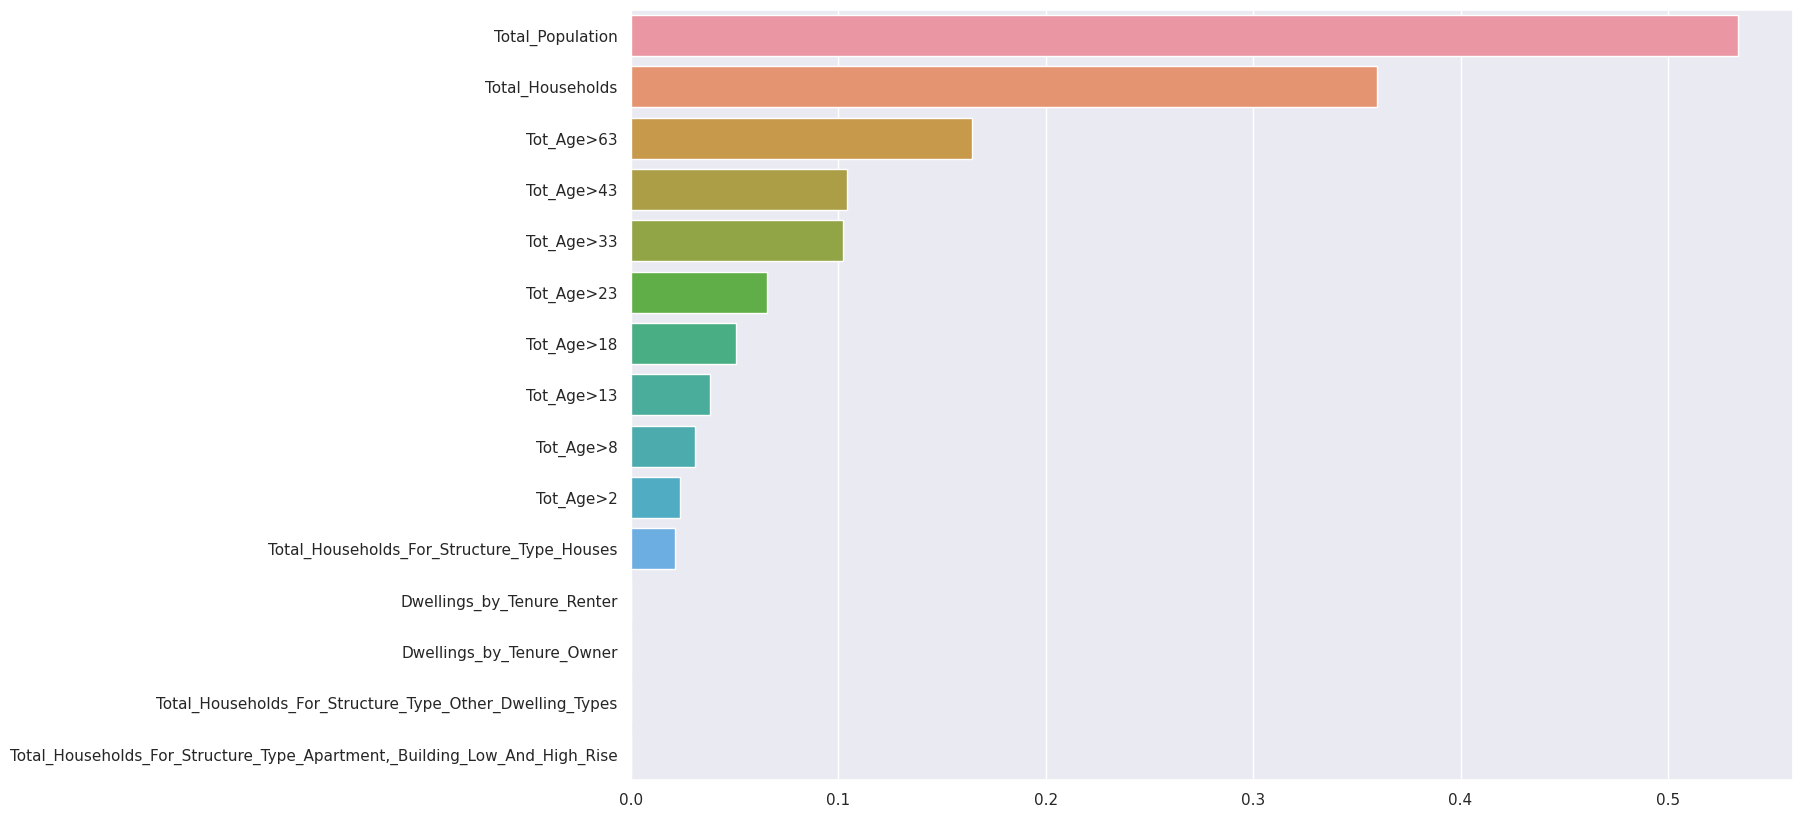

In [133]:
# feature engineering
Features_0 = list(x_cluster0.columns)
lasso_importances_0 = pd.Series(np.abs(best_lasso0.fit(x_train_scaled_cluster0, y_train_scaled_cluster0).coef_), index=Features_0).sort_values(ascending=False)
# Decide on a threshold for keeping features (for example, keep features with importance greater than the average)
mask_0 = lasso_importances_0 > 0
# Use the mask to select the feature names
important_feature_names_0 = x_train_cluster0.columns[mask_0].tolist()
# Sort all features by their importance
sorted_indices_0 = np.argsort(lasso_importances_0)[::-1]
sorted_feature_names_0 = x_train_cluster0.columns[sorted_indices_0]
sorted_importances_0 = lasso_importances_0[sorted_indices_0]
# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x=sorted_importances_0, y=sorted_feature_names_0)

#### KNN

In [134]:
x_0 = cluster0[important_feature_names_0]
y_0 = cluster0['Median_Household_Income_(Current_Year_$)'].values

x_train_0, x_val_0, y_train_0, y_val_0 = train_test_split(
    x_0, y_0, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_0 = MinMaxScaler().fit(x_train_0)
x_train_scaled_0 = scaler_0.transform(x_train_0)
x_val_scaled_0 = scaler_0.transform(x_val_0)

scaler_y_0 = MinMaxScaler()
y_train_scaled_0 = scaler_y_0.fit_transform(y_train_0.reshape(-1, 1))
y_val_scaled_0 = scaler_y_0.transform(y_val_0.reshape(-1, 1))

In [135]:
KNN_0 = KNeighborsRegressor()
KNN_0.fit(x_train_scaled_0, y_train_scaled_0)
# print parameters of model
print('model parameters:', KNN_0.get_params())
# evaluation on train dataset
predict(KNN_0, x_train_scaled_0, y_train_scaled_0, x_val_scaled_0, y_val_scaled_0)

model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Model Performance
mse_train:  0.008229852240225929
r2_train:  0.5875718096289567
mse_test:  0.014730197359427277
r2_test:  0.39794322996474285


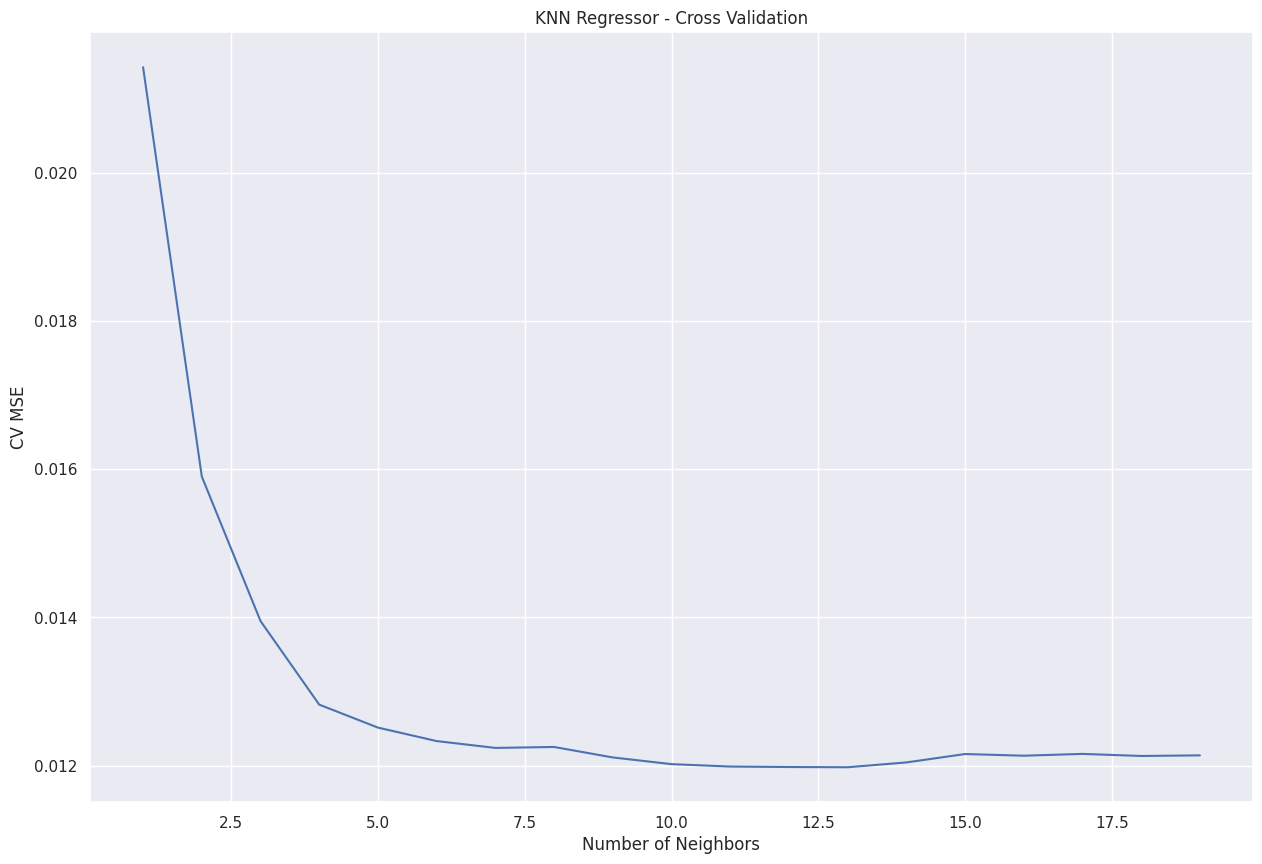

Best k: 13
Model Performance
mse_train:  0.01007948917257417
r2_train:  0.4948796943169458
mse_test:  0.014323561487166857
r2_test:  0.4145633657212332


In [136]:
best_k_0, best_accuracy_0 = find_best_k(x_train_scaled_0, y_train_scaled_0, 20)
print(f"Best k: {best_k_0}")
# Best KNN
best_knn_0 = KNeighborsRegressor(n_neighbors=best_k_0)
predict(best_knn_0, x_train_scaled_0, y_train_scaled_0, x_val_scaled_0, y_val_scaled_0)

### Cluster 1

#### Lasso Regression

In [140]:
## Build logistic regression (lasso)
print('Cluster 1:')
print('-' * 50)
best_lasso1 = LassoCV(cv=20, random_state=1, max_iter=10000)
best_lasso1.fit(x_train_scaled_cluster1, y_train_scaled_cluster1)
print(f'Optimal alpha for the Lasso is {best_lasso1.alpha_}')
predict(best_lasso1, x_train_scaled_cluster1, y_train_scaled_cluster1, x_val_scaled_cluster1, y_val_scaled_cluster1)

Cluster 1:
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal alpha for the Lasso is 0.0002820835449820358


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance
mse_train:  0.010213916689014758
r2_train:  0.5711026034032858
mse_test:  0.009548731299138174
r2_test:  0.5874438777926972


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

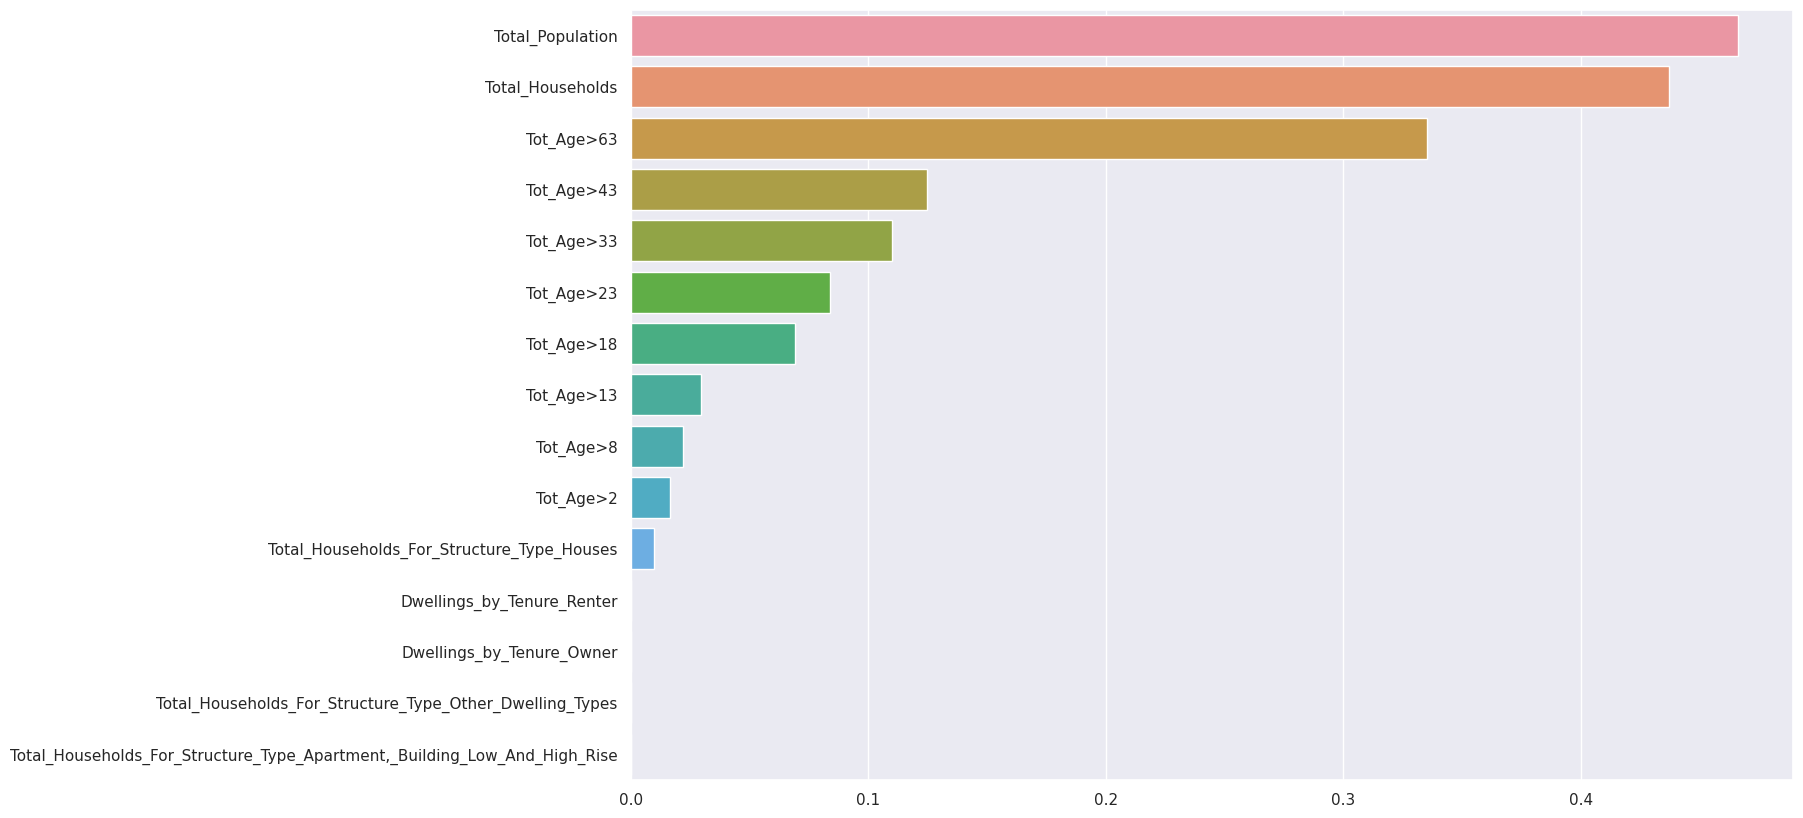

In [138]:
# Feature Engineering for Cluster 1
Features_1 = list(x_cluster1.columns)
lasso_importances_1 = pd.Series(np.abs(best_lasso1.fit(x_train_scaled_cluster1, y_train_scaled_cluster1).coef_), index=Features_1).sort_values(ascending=False)
# Decide on a threshold for keeping features (for example, keep features with importance greater than the average)
mask_1 = lasso_importances_1 > 0
# Use the mask to select the feature names
important_feature_names_1 = x_train_cluster1.columns[mask_1].tolist()
# Sort all features by their importance
sorted_indices_1 = np.argsort(lasso_importances_1)[::-1]
sorted_feature_names_1 = x_train_cluster1.columns[sorted_indices_1]
sorted_importances_1 = lasso_importances_1[sorted_indices_1]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x=sorted_importances_1, y=sorted_feature_names_1)

#### KNN

Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Training accuracy: 0.5981898386220603
Testing accuracy: 0.4103792723696248
Mean Squared Error: 0.013646943030252108


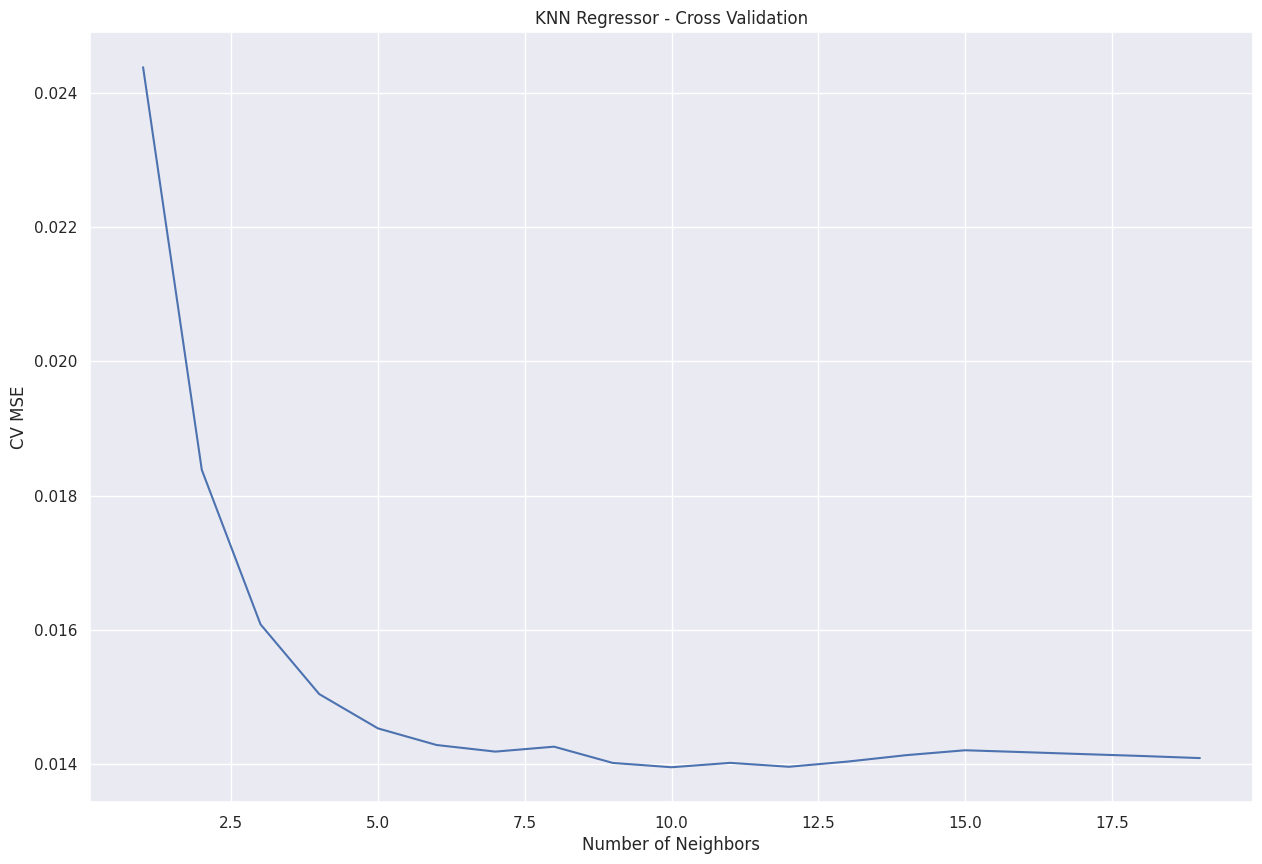

Best k: 10
Model Performance
mse_train:  0.011310045061280645
r2_train:  0.5250745595573573
mse_test:  0.012500178734764375
r2_test:  0.45992560643338776


In [139]:
x_1 = cluster1[important_feature_names_1]
y_1 = cluster1['Median_Household_Income_(Current_Year_$)'].values
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_1, y_1, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_1 = MinMaxScaler().fit(x_train_1)
x_train_scaled_1 = scaler_1.transform(x_train_1)
x_val_scaled_1 = scaler_1.transform(x_val_1)

scaler_y_1 = MinMaxScaler()
y_train_scaled_1 = scaler_y_1.fit_transform(y_train_1.reshape(-1, 1))
y_val_scaled_1 = scaler_y_1.transform(y_val_1.reshape(-1, 1))

KNN_1 = KNeighborsRegressor()
KNN_1.fit(x_train_scaled_1, y_train_scaled_1)
print('Model parameters:', KNN_1.get_params())
KNN_acc_score_train_1 = KNN_1.score(x_train_scaled_1, y_train_scaled_1)
print('Training accuracy:', KNN_acc_score_train_1)

# Evaluation on test dataset
KNN_acc_score_test_1 = KNN_1.score(x_val_scaled_1, y_val_scaled_1)
print('Testing accuracy:', KNN_acc_score_test_1)

# Evaluating the model
y_pred_1 = KNN_1.predict(x_val_scaled_1)
mse_1 = mean_squared_error(y_val_scaled_1, y_pred_1)
print(f"Mean Squared Error: {mse_1}")

best_k_1, best_accuracy_1 = find_best_k(x_train_scaled_1, y_train_scaled_1, 20)
print(f"Best k: {best_k_1}")
# Best KNN
best_knn_1 = KNeighborsRegressor(n_neighbors=best_k_1)
predict(best_knn_1, x_train_scaled_1, y_train_scaled_1, x_val_scaled_1, y_val_scaled_1)

### Cluster 2

#### Lasso regression

In [141]:
print('Cluster 2:')
print('-' * 50)
best_lasso2 = LassoCV(cv=20, random_state=2, max_iter=10000)
best_lasso2.fit(x_train_scaled_cluster2, y_train_scaled_cluster2)
print(f'Optimal alpha for the Lasso is {best_lasso2.alpha_}')
predict(best_lasso2, x_train_scaled_cluster2, y_train_scaled_cluster2, x_val_scaled_cluster2, y_val_scaled_cluster2)

Cluster 2:
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal alpha for the Lasso is 1.4868692585379149e-05


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance
mse_train:  0.005277953220765715
r2_train:  0.5685083343390902
mse_test:  0.006643020942526692
r2_test:  0.5622882410749352


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

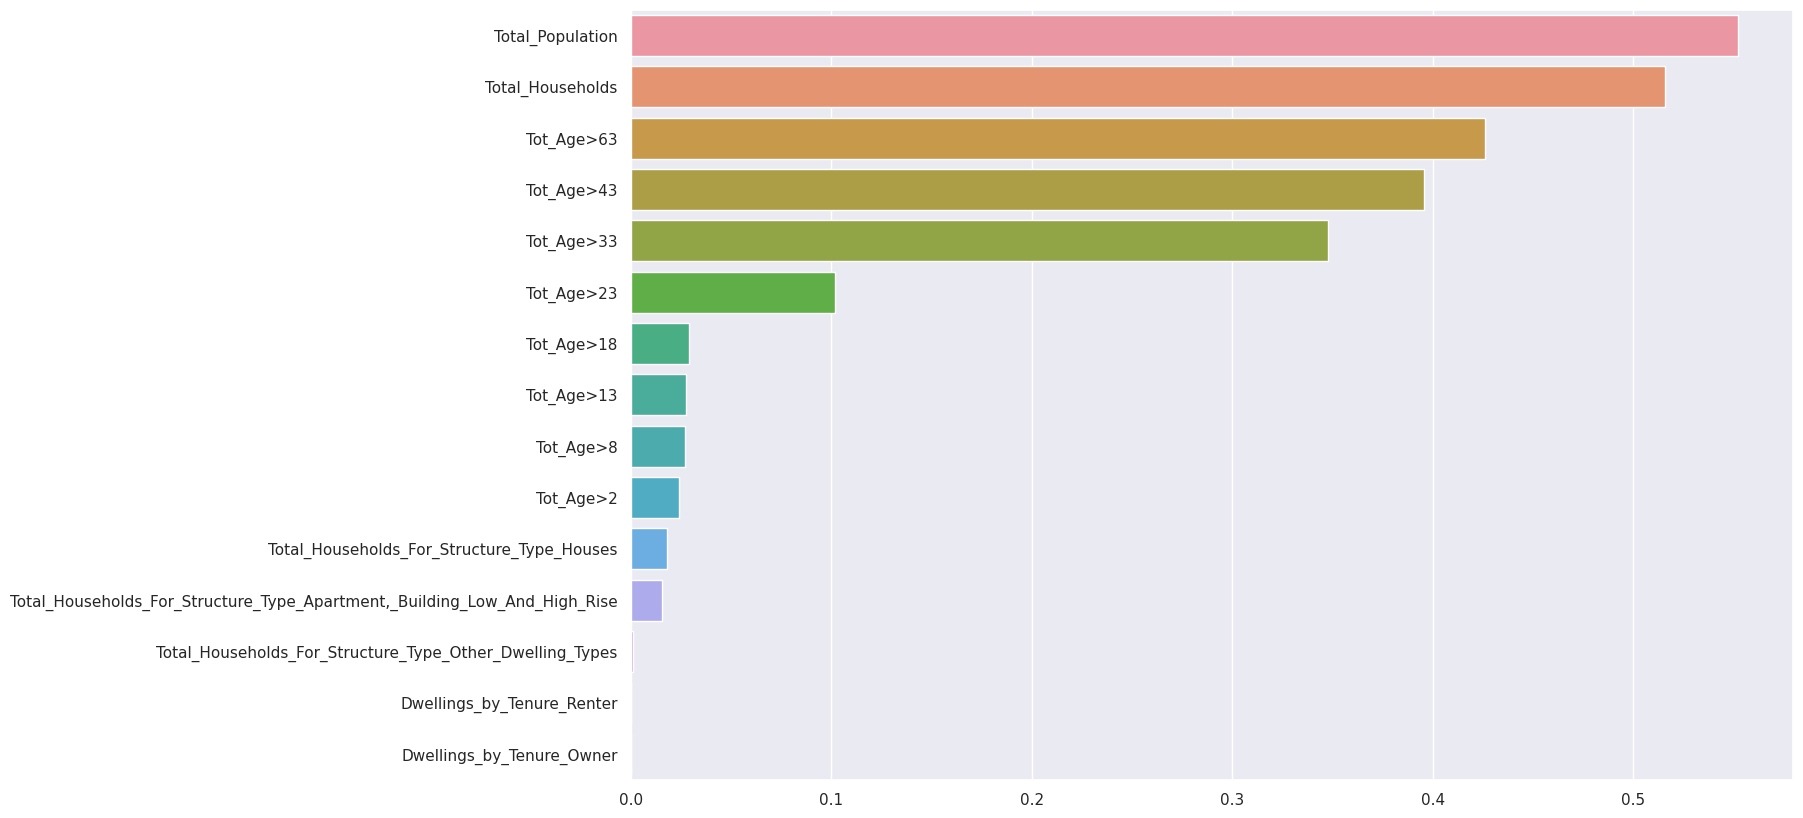

In [142]:
# feature engineering for Cluster 2
Features_2 = list(x_cluster2.columns)
lasso_importances_2 = pd.Series(np.abs(best_lasso2.fit(x_train_scaled_cluster2, y_train_scaled_cluster2).coef_), index=Features_2).sort_values(ascending=False)

# Decide on a threshold for keeping features (for example, keep features with importance greater than the average)
mask_2 = lasso_importances_2 > 0

# Use the mask to select the feature names
important_feature_names_2 = x_train_cluster2.columns[mask_2].tolist()

# Sort all features by their importance
sorted_indices_2 = np.argsort(lasso_importances_2)[::-1]
sorted_feature_names_2 = x_train_cluster2.columns[sorted_indices_2]
sorted_importances_2 = lasso_importances_2[sorted_indices_2]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x=sorted_importances_2, y=sorted_feature_names_2)

#### KNN

Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Training accuracy: 0.6585479756033661
Testing accuracy: 0.4570236822374326
Mean Squared Error: 0.008240589786874501


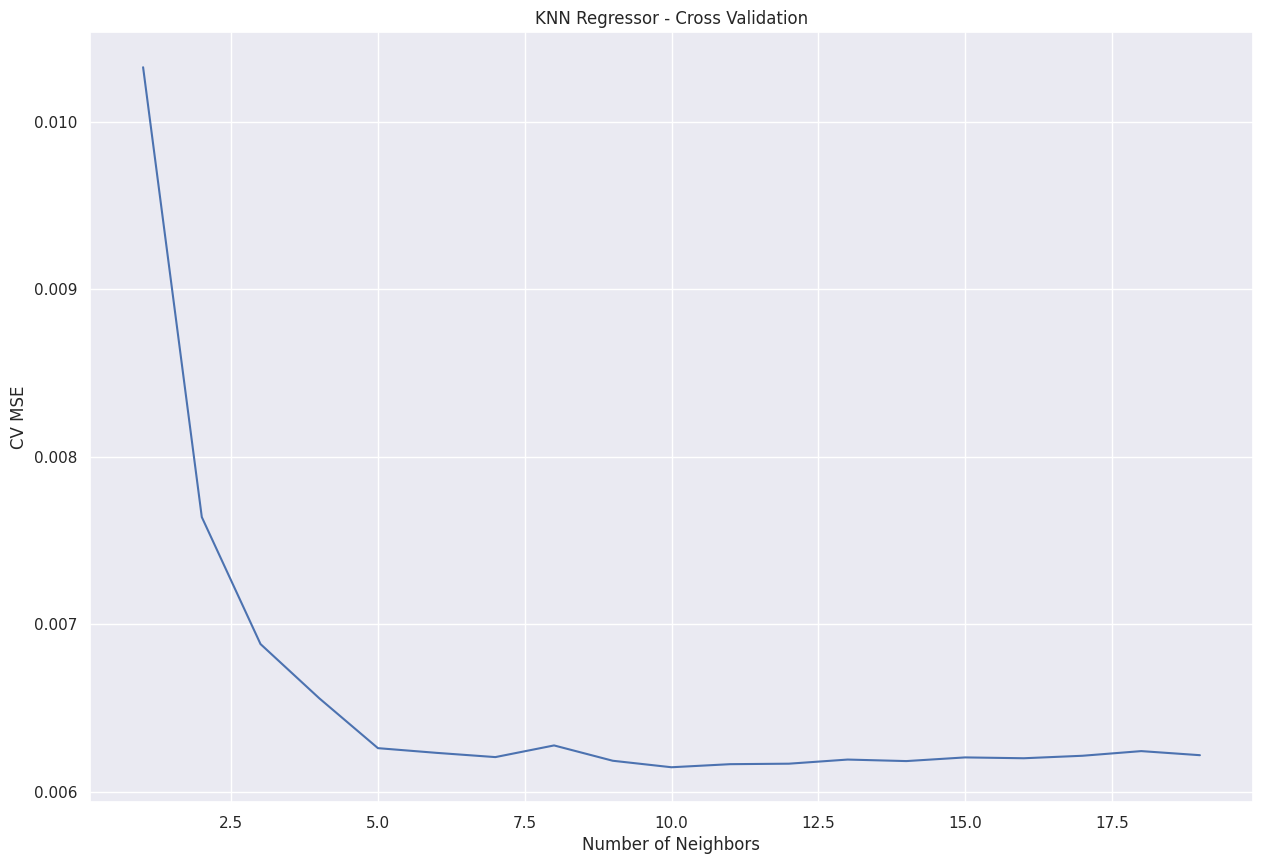

Best k: 10
Model Performance
mse_train:  0.005009657067332338
r2_train:  0.5904425102010329
mse_test:  0.007905379390149488
r2_test:  0.47911085216055904


In [143]:
x_2 = cluster2[important_feature_names_2]
y_2 = cluster2['Median_Household_Income_(Current_Year_$)'].values
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2, y_2, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_2 = MinMaxScaler().fit(x_train_2)
x_train_scaled_2 = scaler_2.transform(x_train_2)
x_val_scaled_2 = scaler_2.transform(x_val_2)

scaler_y_2 = MinMaxScaler()
y_train_scaled_2 = scaler_y_2.fit_transform(y_train_2.reshape(-1, 1))
y_val_scaled_2 = scaler_y_2.transform(y_val_2.reshape(-1, 1))

KNN_2 = KNeighborsRegressor()
KNN_2.fit(x_train_scaled_2, y_train_scaled_2)
print('Model parameters:', KNN_2.get_params())
KNN_acc_score_train_2 = KNN_2.score(x_train_scaled_2, y_train_scaled_2)
print('Training accuracy:', KNN_acc_score_train_2)

# Evaluation on test dataset
KNN_acc_score_test_2 = KNN_2.score(x_val_scaled_2, y_val_scaled_2)
print('Testing accuracy:', KNN_acc_score_test_2)

# Evaluating the model
y_pred_2 = KNN_2.predict(x_val_scaled_2)
mse_2 = mean_squared_error(y_val_scaled_2, y_pred_2)
print(f"Mean Squared Error: {mse_2}")

best_k_2, best_accuracy_2 = find_best_k(x_train_scaled_2, y_train_scaled_2, 20)
print(f"Best k: {best_k_2}")
# Best KNN
best_knn_2 = KNeighborsRegressor(n_neighbors=best_k_2)
predict(best_knn_2, x_train_scaled_2, y_train_scaled_2, x_val_scaled_2, y_val_scaled_2)

### Cluter 3

#### Lasso regression

In [144]:
print('Cluster 3:')
print('-' * 50)
best_lasso3 = LassoCV(cv=20, random_state=3, max_iter=10000)
best_lasso3.fit(x_train_scaled_cluster3, y_train_scaled_cluster3)
print(f'Optimal alpha for the Lasso is {best_lasso3.alpha_}')
predict(best_lasso3, x_train_scaled_cluster3, y_train_scaled_cluster3, x_val_scaled_cluster3, y_val_scaled_cluster3)

Cluster 3:
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal alpha for the Lasso is 7.56933073691026e-05


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance
mse_train:  0.0128344929661522
r2_train:  0.6540728673593158
mse_test:  0.02091874821385085
r2_test:  0.42914399911037904


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

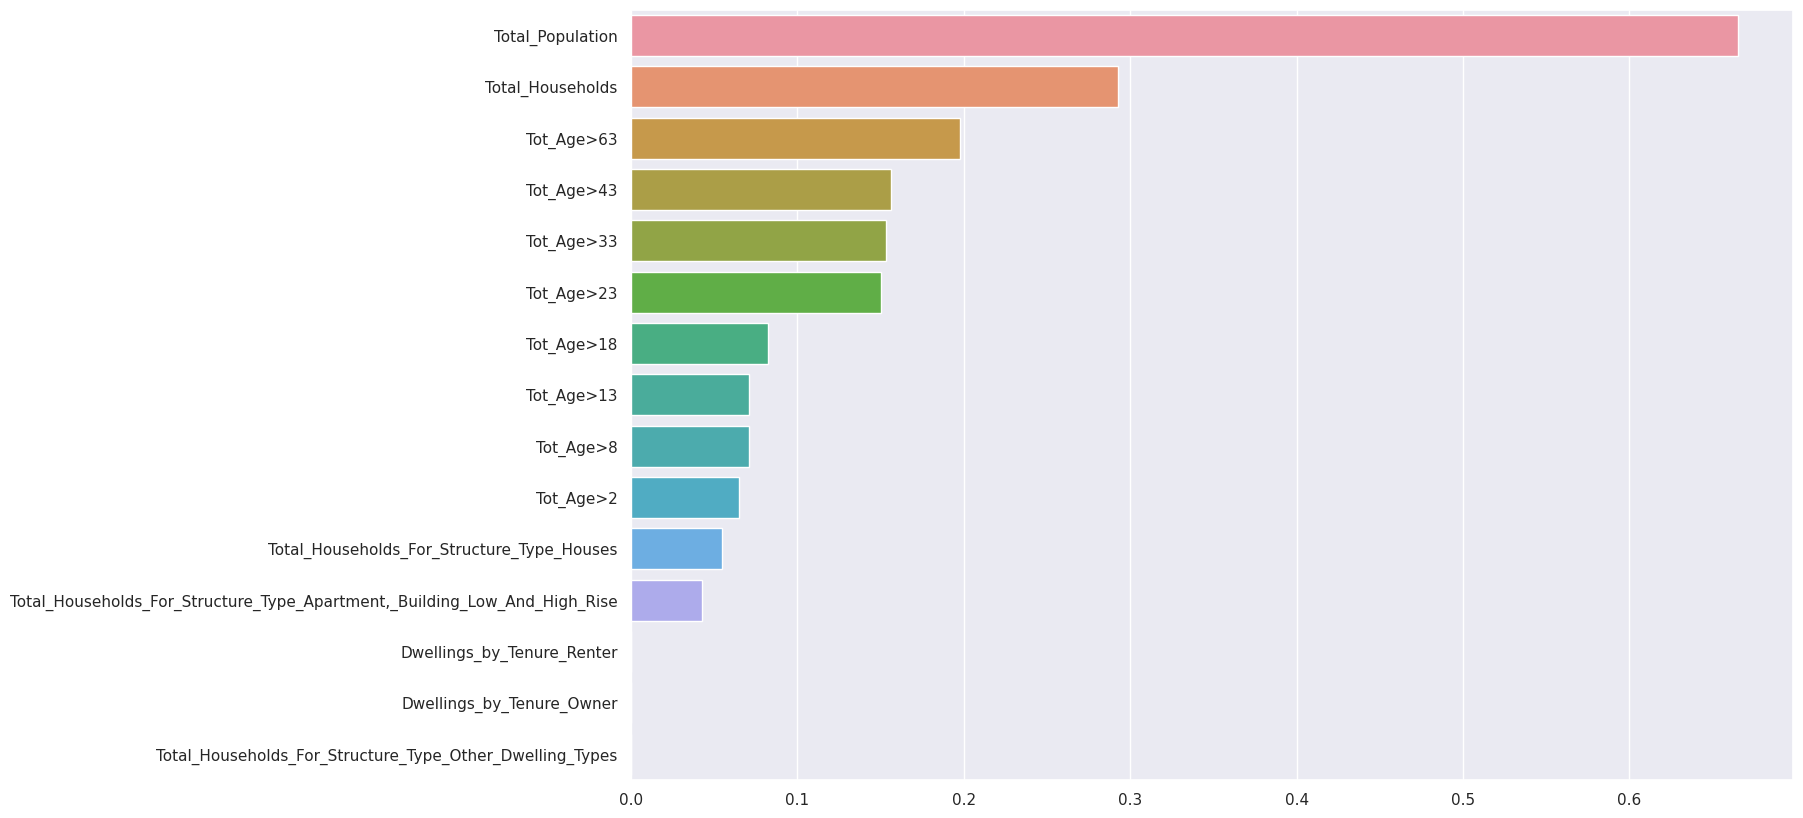

In [145]:
# feature engineering for Cluster 3
Features_3 = list(x_cluster3.columns)
lasso_importances_3 = pd.Series(np.abs(best_lasso3.fit(x_train_scaled_cluster3, y_train_scaled_cluster3).coef_), index=Features_3).sort_values(ascending=False)

# Decide on a threshold for keeping features (for example, keep features with importance greater than the average)
mask_3 = lasso_importances_3 > 0

# Use the mask to select the feature names
important_feature_names_3 = x_train_cluster3.columns[mask_3].tolist()

# Sort all features by their importance
sorted_indices_3 = np.argsort(lasso_importances_3)[::-1]
sorted_feature_names_3 = x_train_cluster3.columns[sorted_indices_3]
sorted_importances_3 = lasso_importances_3[sorted_indices_3]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x=sorted_importances_3, y=sorted_feature_names_3)

#### KNN

Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Training accuracy: 0.7416572896455791
Testing accuracy: 0.46375070083882064
Mean Squared Error: 0.01965060199336629


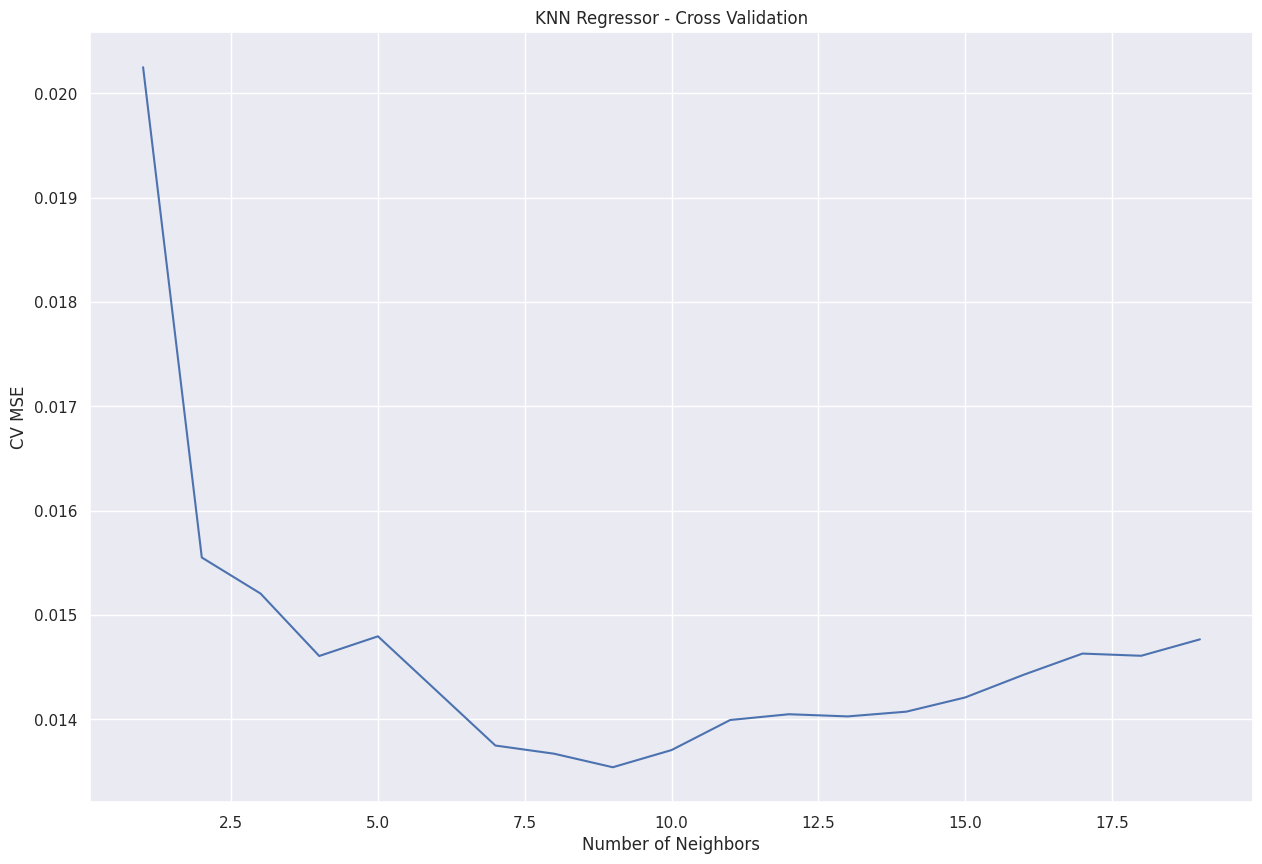

Best k: 9
Model Performance
mse_train:  0.01069520533149729
r2_train:  0.7117329275815241
mse_test:  0.018708943788173053
r2_test:  0.4894478043043895


In [146]:
x_3 = cluster3[important_feature_names_3]
y_3 = cluster3['Median_Household_Income_(Current_Year_$)'].values
x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(x_3, y_3, test_size=validation_ratio, random_state=1, shuffle=True)

scaler_3 = MinMaxScaler().fit(x_train_3)
x_train_scaled_3 = scaler_3.transform(x_train_3)
x_val_scaled_3 = scaler_3.transform(x_val_3)

scaler_y_3 = MinMaxScaler()
y_train_scaled_3 = scaler_y_3.fit_transform(y_train_3.reshape(-1, 1))
y_val_scaled_3 = scaler_y_3.transform(y_val_3.reshape(-1, 1))

KNN_3 = KNeighborsRegressor()
KNN_3.fit(x_train_scaled_3, y_train_scaled_3)
print('Model parameters:', KNN_3.get_params())
KNN_acc_score_train_3 = KNN_3.score(x_train_scaled_3, y_train_scaled_3)
print('Training accuracy:', KNN_acc_score_train_3)
# Evaluation on test dataset
KNN_acc_score_test_3 = KNN_3.score(x_val_scaled_3, y_val_scaled_3)
print('Testing accuracy:', KNN_acc_score_test_3)
# Evaluating the model
y_pred_3 = KNN_3.predict(x_val_scaled_3)
mse_3 = mean_squared_error(y_val_scaled_3, y_pred_3)
print(f"Mean Squared Error: {mse_3}")
# Hyperparameter Tuning
best_k_3, best_accuracy_3 = find_best_k(x_train_scaled_3, y_train_scaled_3, 20)
print(f"Best k: {best_k_3}")
# Best KNN
best_knn_3 = KNeighborsRegressor(n_neighbors=best_k_3)
predict(best_knn_3, x_train_scaled_3, y_train_scaled_3, x_val_scaled_3, y_val_scaled_3)

# Testing Data

In [20]:
# read testing dataset
df_test = pd.read_csv('CensusCanada2021Test.csv') # change the csv path for your version
df_test.columns = df_test.columns.str.replace(' ','_')
# replace "?" into None
# df_test = df_test.replace('?', np.NaN)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 17 columns):
 #   Column                                                                     Non-Null Count  Dtype
---  ------                                                                     --------------  -----
 0   Total_Population                                                           855 non-null    int64
 1   Total_Households                                                           855 non-null    int64
 2   Total_Households_For_Period_Of_Construction                                855 non-null    int64
 3   Total_Households_For_Period_Of_Construction_Built_Before_1961              855 non-null    int64
 4   Total_Households_For_Period_Of_Construction_Built_Between_1961_And_1980    855 non-null    int64
 5   Total_Households_For_Period_Of_Construction_Built_Between_1981_And_190     855 non-null    int64
 6   Total_Households_For_Period_Of_Construction_Built_Between_1991_And_2000   

In [21]:
# list of variables containing null value
na_lst_test = df_test.columns[df_test.isna().any()].tolist()
print('Testing Dataset: here is the list of variables containing null-value: ', na_lst_test)

Testing Dataset: here is the list of variables containing null-value:  []


None of the variables is missing in the testing dataset.

In [22]:
# drop two of the duplicate rows)
dup1 = ['Total_Households_For_Period_Of_Construction', 'Total_Households_for_Tenure']
df_test = df_test.drop(columns = dup1)
# rename the variables
df_test.rename(columns={'Total_Households_For_Period_Of_Construction_Built_Before_1961': 'Tot_Age>63', 'Total_Households_For_Period_Of_Construction_Built_Between_1961_And_1980': 'Tot_Age>43',
                    'Total_Households_For_Period_Of_Construction_Built_Between_1981_And_190': 'Tot_Age>33', 'Total_Households_For_Period_Of_Construction_Built_Between_1991_And_2000': 'Tot_Age>23',
                    'Total_Households_For_Period_Of_Construction_Built_Between_2001_And_2005': 'Tot_Age>18', 'Total_Households_For_Period_Of_Construction_Built_Between_2006_And_2010': 'Tot_Age>13',
                    'Total_Households_For_Period_Of_Construction_Built_Between_2011_And_2015': 'Tot_Age>8', 'Total_Households_For_Period_Of_Construction_Built_Between_2016_And_2021': 'Tot_Age>2'},inplace=True)

In [23]:
important_feature_names =  ['Total_Population', 'Total_Households', 'Tot_Age>63', 'Tot_Age>43', 'Tot_Age>33', 'Tot_Age>8', 'Total_Households_For_Structure_Type_Houses', 'Total_Households_For_Structure_Type_Apartment,_Building_Low_And_High_Rise', 'Dwellings_by_Tenure_Owner', 'Dwellings_by_Tenure_Renter']
x_test = df_test[important_feature_names]
x_test_scaled = Scaler.transform(x_test)

In [30]:
# Make predictions with best model
test_predictions = best_ann.predict(x_test_scaled)

27/27 [==============================] - 0s 888us/step


In [31]:
test_predictions = Scaler_y.inverse_transform(test_predictions)
test_predictions.flatten().tolist()

[48341.8671875,
 73394.5546875,
 78069.515625,
 43540.03125,
 67602.5546875,
 91430.1875,
 88131.609375,
 80675.09375,
 61814.4375,
 94256.9140625,
 72896.1015625,
 86741.2421875,
 78561.875,
 101146.671875,
 63789.22265625,
 73339.1328125,
 104116.9296875,
 48973.4765625,
 86516.1796875,
 71806.5546875,
 39611.9453125,
 94463.7734375,
 85508.7265625,
 65174.91796875,
 57961.11328125,
 70942.0390625,
 58096.96875,
 46899.921875,
 85580.6171875,
 98140.765625,
 92752.6953125,
 118617.578125,
 96059.4140625,
 90980.203125,
 65707.7109375,
 92172.1171875,
 44711.0390625,
 62012.97265625,
 58742.8125,
 84321.4375,
 54320.99609375,
 57088.86328125,
 88963.71875,
 101713.6484375,
 56170.38671875,
 72201.2109375,
 92808.8046875,
 64137.375,
 88985.6484375,
 97393.4609375,
 66823.8984375,
 99729.9921875,
 79834.453125,
 101823.609375,
 62690.58203125,
 85952.1875,
 113461.953125,
 58274.6875,
 46826.62109375,
 72134.953125,
 69782.53125,
 56217.3515625,
 54752.85546875,
 86219.28125,
 84437.67

In [34]:
# Export as ASCII file
filename = f"Team17predictions.txt"
pd.DataFrame(test_predictions.flatten().tolist()).to_csv(filename, header=False, index=False)